**Importing important libraries and function** 

In [1]:
from keras.datasets import mnist
from keras.utils import np_utils 
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.layers.normalization import BatchNormalization
from keras.initializers import RandomNormal, glorot_normal, he_normal

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

Using TensorFlow backend.


* **Load the data and Normalazie it**
* **Define the batch size and epochs**

In [2]:
# the data, shuffled and split between train and test sets 
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Number of training examples :", X_train.shape[0], 
      "and each image is of shape (%d, %d)"%(X_train.shape[1], X_train.shape[2]))
print("Number of training examples :", X_test.shape[0], 
      "and each image is of shape (%d, %d)"%(X_test.shape[1], X_test.shape[2]))

#pixcels values are from 0-255, so divide each pixel by 255 (to noramalize)
X_train, X_test = X_train/255, X_test/255

#converting labels into one-hot encoded: there are 10 labels so new vector will be 10 dimensional
Y_train = np_utils.to_categorical(y_train, 10) 
Y_test = np_utils.to_categorical(y_test, 10)
print("Class label of first image :", y_train[0])
print("After converting the output into a vector : ",Y_train[0])

batch_size = 128 #2^7
epochs = 20
num_class = 10

#defining pretty table: http://zetcode.com/python/prettytable/
table = PrettyTable()
table.field_names = ['Architecture', "Activation", "W's Initializer", "Regularizer", "Test Loss", "Test Accuracy"]

11493376/11490434 [==============================] - 2s 0us/step
Number of training examples : 60000 and each image is of shape (28, 28)
Number of training examples : 10000 and each image is of shape (28, 28)
Class label of first image : 5
After converting the output into a vector :  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


* Each input of train and test data in 3-dimension but Conv2D will need 4dimension input. So adding one more dimension in train and test data.

In [3]:
print('Shape of X_train is: ', X_train.shape, 'So each input will have {} dimensions'.format(len(X_train.shape)))
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('After adding one more dimension shape of train data is: ', X_train.shape, 'each input has {} dimensions'.format(len(X_train.shape)))

Shape of X_train is:  (60000, 28, 28) So each input will have 3 dimensions
After adding one more dimension shape of train data is:  (60000, 28, 28, 1) each input has 4 dimensions


**NOTE:** 
* I'll keep my optimizer as **Adam** and activation as **ReLU/tanh**.
* I'll choose two different types of kerenl (3x3), (5x5) and (7,7) for ConvNet and (2,2), (3,3) and (5,5) for max pool.
* I'll use two different weight initializer **He-normal** and **Glorot-normal**.


# 1. With 3-CovNet Layers

**References**
* https://keras.io/layers/convolutional/
* https://keras.io/initializers/
* https://keras.io/layers/pooling/
* https://keras.io/optimizers/
* https://keras.io/layers/pooling/

In [0]:
def report_model(model, history):
    score = model.evaluate(X_test, Y_test, verbose = 0)
    print('Test loss: ', score[0])
    print('Test accuracy: ', score[1])

    train_loss = history.history['loss']
    cv_loss    = history.history['val_loss']

    plt.figure(figsize = (8, 6))
    plt.plot(range(1, epochs+1), train_loss, label = 'Train')
    plt.plot(range(1, epochs+1), cv_loss, label = 'CV')
    plt.xticks(range(1,21))
    plt.legend(fontsize = 12)
    plt.grid(1)
    plt.xlabel('#epochs', fontsize = 12)
    plt.ylabel('Error (categorical cross entropy)', fontsize = 12)
    plt.title('loss vs epochs', fontsize = 14)
    plt.show()
    
    return score, train_loss, cv_loss

## 1.1 With *`Tanh`* Activation

**Achitecture**
* Without **Batch Normalization and Dropout**
  * ***input --> ConvNet(3,3)16 --> tanh --> ConveNet(3,3)32 --> tanh --> ConvNet(3,3)64 --> MaxPooling[(3,3),s=3] --> flatten --> 1FC layer(512) --> softmax(10)***
* With **Batch Normalization and Dropout**
  * ***input --> ConvNet(3,3)16 --> tanh --> ConveNet(3,3)32 --> tanh --> batch normalization+dropout(0.5) --> ConvNet(3,3)64 --> MaxPooling[(3,3),s=3] --> flatten --> 1FC layer(512) --> softmax(10)***


### 1.1.1 Weight Initializer (He-Normal)

#### 1.1.1.1 Without Batch Normalization + Dropout

In [5]:
model1_1 = Sequential()
#first ConvNet Layer
model1_1.add(Conv2D(16, kernel_size = (3,3), activation = 'tanh', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1),
                 kernel_initializer = he_normal(seed = None), data_format = 'channels_last', name = 'Conv2d_1'))

#second ConvNet Layer
model1_1.add(Conv2D(32, kernel_size = (3,3), activation = 'tanh', padding = 'same',
                kernel_initializer = he_normal(seed = None), name = 'Conv2d_2'))

#third ConvNet Layer
model1_1.add(Conv2D(64, kernel_size = (3,3), activation = 'tanh', padding = 'same',
                kernel_initializer = he_normal(42), name = 'Conv2d_3'))

# adding MaxPooling
model1_1.add(MaxPooling2D(pool_size = (3,3), padding = 'same', strides = 3, name = 'max_poo_1')) #by deafult strides pool_size

#flatten
model1_1.add(Flatten(name = 'Flatten'))
# fully connected layer: layer-4
model1_1.add(Dense(512, activation = 'tanh', kernel_initializer = he_normal(seed = None), name = 'FC_1'))

#output layer
model1_1.add(Dense(num_class, activation = 'softmax', kernel_initializer = he_normal(seed = None), name = 'Softmax'))

model1_1.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
Conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
Conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_poo_1 (MaxPooling2D)     (None, 10, 10, 64)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
FC_1 (Dense)                 (None, 512)               3277312   
_________________________________________________________________
Softmax (Dense)              (None, 10)           

In [6]:
model1_1.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model1_1.fit(X_train, Y_train, validation_data = (X_test,Y_test),epochs = epochs, batch_size = batch_size, verbose = 1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 19s 314us/step - loss: 0.2350 - acc: 0.9500 - val_loss: 0.0478 - val_acc: 0.9851
Epoch 2/20
60000/60000 [==============================] - 12s 203us/step - loss: 0.0388 - acc: 0.9881 - val_loss: 0.0452 - val_acc: 0.9849
Epoch 3/20
60000/60000 [==============================] - 12s 200us/step - loss: 0.0215 - acc: 0.9936 - val_loss: 0.0402 - val_acc: 0.9862
Epoch 4/20
60000/60000 [==============================] - 12s 200us/step - loss: 0.0146 - acc: 0.9956 - val_loss: 0.0367 - val_acc: 0.9880
Epoch 5/20
60000/60000 [==============================] - 12s 199us/step - loss: 0.0104 - acc: 0.9968 - val_loss: 0.0359 - val_acc: 0.9886
Epoch 6/20
60000/60000 [==============================] - 12s 201us/step - loss: 0.0077 - acc: 0.9980 - val_loss: 0.0310 - val_acc: 0.9907
Epoch 7/20
60000/60

Test loss:  0.047172877471583344
Test accuracy:  0.9872


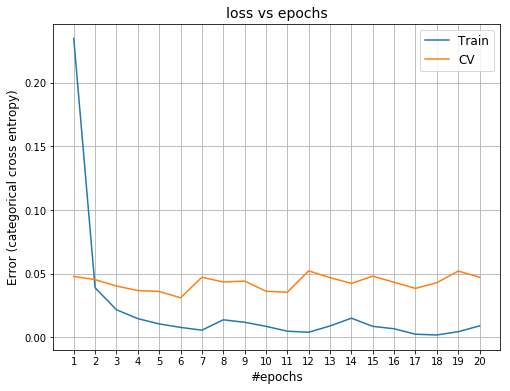

In [7]:
score1_1, train_loss1_1, cv_loss1_1  = report_model(model1_1, history)
table.add_row(['3 ConvNet', 'tanh', 'He-normal','None', round(score1_1[0],5), round(score1_1[1],5)])

#### 1.1.1.2 With Batch Normalization + Dropout

In [8]:
model1_2 = Sequential()
#first ConvNet Layer
model1_2.add(Conv2D(16, kernel_size = (3,3), activation = 'tanh', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1),
                 kernel_initializer = he_normal(seed = None), data_format = 'channels_last'))

#second ConvNet Layer
model1_2.add(Conv2D(32, kernel_size = (3,3), activation = 'tanh', padding = 'same',
                kernel_initializer = he_normal(seed = None)))
#adding BatchNomralization layer
model1_2.add(BatchNormalization())
# adding dropout
model1_2.add(Dropout(0.3))

#third ConvNet Layer
model1_2.add(Conv2D(64, kernel_size = (3,3), activation = 'tanh', padding = 'same',
                kernel_initializer = he_normal(seed = None)))

# adding MaxPooling
model1_2.add(MaxPooling2D(pool_size = (3,3), padding = 'same', strides = 3)) #by deafult strides pool_size

#flatten
model1_2.add(Flatten())

# fully connected layer: layer-4
model1_2.add(Dense(512, activation = 'tanh', kernel_initializer = he_normal(seed = None)))

#output layer
model1_2.add(Dense(num_class, activation = 'softmax', kernel_initializer = he_normal(seed = None)))

model1_2.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
____

In [9]:
model1_2.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model1_2.fit(X_train, Y_train, validation_data = (X_test,Y_test),epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 15s 252us/step - loss: 1.9965 - acc: 0.7981 - val_loss: 1.7233 - val_acc: 0.8561
Epoch 2/20
60000/60000 [==============================] - 14s 240us/step - loss: 1.6507 - acc: 0.8794 - val_loss: 1.9847 - val_acc: 0.7975
Epoch 3/20
60000/60000 [==============================] - 14s 239us/step - loss: 1.6270 - acc: 0.8862 - val_loss: 1.8968 - val_acc: 0.8199
Epoch 4/20
60000/60000 [==============================] - 14s 240us/step - loss: 0.3101 - acc: 0.9627 - val_loss: 0.0576 - val_acc: 0.9824
Epoch 5/20
60000/60000 [==============================] - 14s 239us/step - loss: 0.0531 - acc: 0.9839 - val_loss: 0.0775 - val_acc: 0.9763
Epoch 6/20
60000/60000 [==============================] - 15s 243us/step - loss: 0.0439 - acc: 0.9866 - val_loss: 0.0547 - val_acc: 0.9831
Epoch 7/20
60000/60000 [==============================] - 14s 240us/step - loss: 0.0404 - acc: 0.9879 - val_loss: 0.

Test loss:  0.042994664606268634
Test accuracy:  0.9859


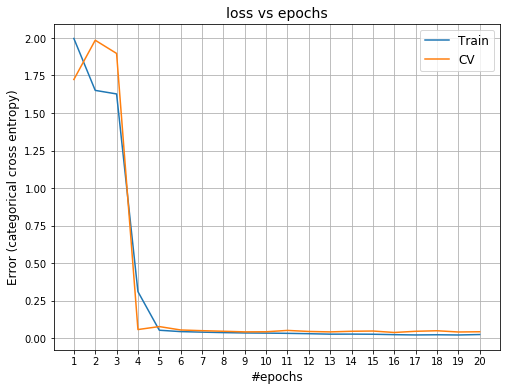

In [10]:
score1_2, train_loss1_2, cv_loss1_2  = report_model(model1_2, history)
table.add_row(['3 ConvNet', 'tanh', 'He-normal','BN + Dropout', round(score1_2[0],5), round(score1_2[1],5)])

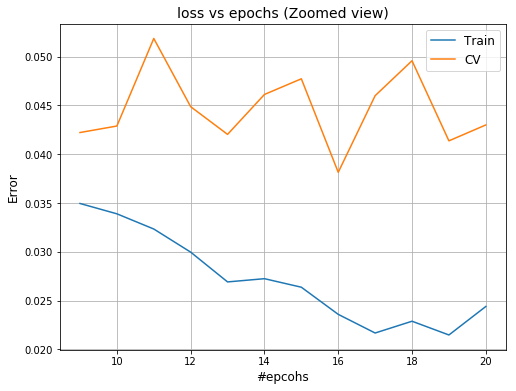

In [11]:
plt.figure(figsize = (8,6))
plt.plot(range(9, 21), train_loss1_2[8:], label = 'Train')
plt.plot(range(9,21), cv_loss1_2[8:], label = 'CV')
plt.title('loss vs epochs (Zoomed view)', fontsize = 14)
plt.xlabel('#epcohs', fontsize = 12)
plt.ylabel('Error', fontsize = 12)
plt.legend(fontsize = 12)
plt.grid(1)
plt.show()

### 1.1.2 Weight Initializer (Glorot-Normal)

#### 1.1.2.1 Without Batch Normalization + Dropout

In [12]:
model1_3 = Sequential()
#first ConvNet Layer
model1_3.add(Conv2D(16, kernel_size = (3,3), activation = 'tanh', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1),
                 kernel_initializer = glorot_normal(seed = None), data_format = 'channels_last', name = 'Conv2d_1'))

#second ConvNet Layer
model1_3.add(Conv2D(32, kernel_size = (3,3), activation = 'tanh', padding = 'same',
                kernel_initializer = glorot_normal(seed = None), name = 'Conv2d_2'))

#third ConvNet Layer
model1_3.add(Conv2D(64, kernel_size = (3,3), activation = 'tanh', padding = 'same',
                kernel_initializer = glorot_normal(42), name = 'Conv2d_3'))

# adding MaxPooling
model1_3.add(MaxPooling2D(pool_size = (3,3), padding = 'same', strides = 3, name = 'max_poo_1')) #by deafult strides pool_size

#flatten
model1_3.add(Flatten(name = 'Flatten'))
# fully connected layer: layer-4
model1_3.add(Dense(512, activation = 'tanh', kernel_initializer = glorot_normal(seed = None), name = 'FC_1'))

#output layer
model1_3.add(Dense(num_class, activation = 'softmax', kernel_initializer = glorot_normal(seed = None), name = 'Softmax'))

model1_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
Conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
Conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_poo_1 (MaxPooling2D)     (None, 10, 10, 64)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
FC_1 (Dense)                 (None, 512)               3277312   
_________________________________________________________________
Softmax (Dense)              (None, 10)               

In [13]:
model1_3.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model1_3.fit(X_train, Y_train, validation_data = (X_test,Y_test),epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 13s 218us/step - loss: 0.1391 - acc: 0.9571 - val_loss: 0.0626 - val_acc: 0.9801
Epoch 2/20
60000/60000 [==============================] - 12s 203us/step - loss: 0.0439 - acc: 0.9863 - val_loss: 0.0400 - val_acc: 0.9873
Epoch 3/20
60000/60000 [==============================] - 12s 204us/step - loss: 0.0243 - acc: 0.9924 - val_loss: 0.0421 - val_acc: 0.9870
Epoch 4/20
60000/60000 [==============================] - 12s 203us/step - loss: 0.0149 - acc: 0.9954 - val_loss: 0.0388 - val_acc: 0.9885
Epoch 5/20
60000/60000 [==============================] - 12s 206us/step - loss: 0.0095 - acc: 0.9970 - val_loss: 0.0378 - val_acc: 0.9872
Epoch 6/20
60000/60000 [==============================] - 12s 204us/step - loss: 0.0073 - acc: 0.9980 - val_loss: 0.0378 - val_acc: 0.9879
Epoch 7/20
60000/60000 [==============================] - 12s 203us/step - loss: 0.0084 - acc: 0.9974 - val_loss: 0.

Test loss:  0.046934204362524545
Test accuracy:  0.9874


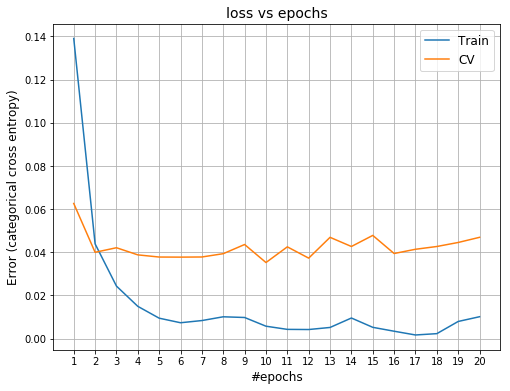

In [14]:
score1_3, train_loss1_3, cv_loss1_3  = report_model(model1_3, history)
table.add_row(['3 ConvNet', 'tanh', 'Glorot-normal','None', round(score1_3[0],5), round(score1_3[1],5)])

#### 1.1.2.2 With Batch Normalization + Dropout

In [15]:
model1_4 = Sequential()
#first ConvNet Layer
model1_4.add(Conv2D(16, kernel_size = (3,3), activation = 'tanh', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1),
                 kernel_initializer = glorot_normal(seed = None), data_format = 'channels_last'))

#second ConvNet Layer
model1_4.add(Conv2D(32, kernel_size = (3,3), activation = 'tanh', padding = 'same',
                kernel_initializer = glorot_normal(seed = None)))
#adding BatchNomralization layer
model1_4.add(BatchNormalization())
# adding dropout
model1_4.add(Dropout(0.3))

#third ConvNet Layer
model1_4.add(Conv2D(64, kernel_size = (3,3), activation = 'tanh', padding = 'same',
                kernel_initializer = glorot_normal(seed = None)))

# adding MaxPooling
model1_4.add(MaxPooling2D(pool_size = (3,3), padding = 'same', strides = 3)) #by deafult strides pool_size

#flatten
model1_4.add(Flatten())

# fully connected layer: layer-4
model1_4.add(Dense(512, activation = 'tanh', kernel_initializer = glorot_normal(seed = None)))

#output layer
model1_4.add(Dense(num_class, activation = 'softmax', kernel_initializer = glorot_normal(seed = None)))

model1_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6400)             

In [16]:
model1_4.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model1_4.fit(X_train, Y_train, validation_data = (X_test,Y_test),epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 15s 254us/step - loss: 1.8559 - acc: 0.8350 - val_loss: 2.7489 - val_acc: 0.7346
Epoch 2/20
60000/60000 [==============================] - 14s 239us/step - loss: 1.6656 - acc: 0.8820 - val_loss: 3.3029 - val_acc: 0.7341
Epoch 3/20
60000/60000 [==============================] - 14s 240us/step - loss: 1.6471 - acc: 0.8867 - val_loss: 2.0603 - val_acc: 0.8248
Epoch 4/20
60000/60000 [==============================] - 14s 240us/step - loss: 1.6401 - acc: 0.8884 - val_loss: 1.6706 - val_acc: 0.8850
Epoch 5/20
60000/60000 [==============================] - 15s 243us/step - loss: 1.6340 - acc: 0.8902 - val_loss: 1.6799 - val_acc: 0.8817
Epoch 6/20
60000/60000 [==============================] - 14s 241us/step - loss: 1.6300 - acc: 0.8907 - val_loss: 1.6581 - val_acc: 0.8897
Epoch 7/20
60000/60000 [==============================] - 14s 241us/step - loss: 1.6290 - acc: 0.8913 - val_loss: 1.

Test loss:  0.03855411749085179
Test accuracy:  0.9873


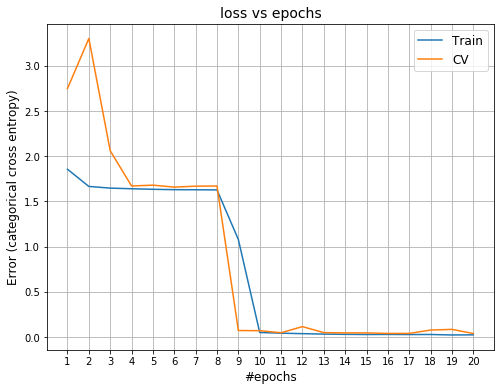

In [17]:
score1_4, train_loss1_4, cv_loss1_4  = report_model(model1_4, history)
table.add_row(['3 ConvNet', 'tanh', 'Glorot-normal','BN + Dropout', round(score1_4[0],5), round(score1_4[1],5)])

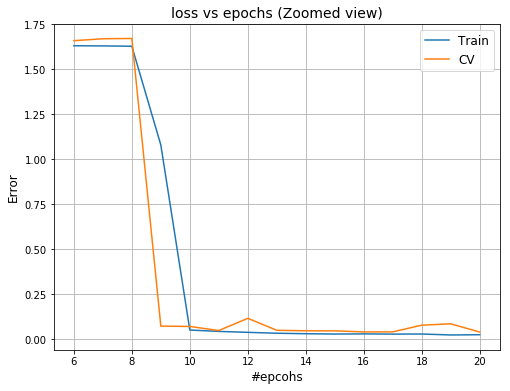

In [18]:
plt.figure(figsize = (8,6))
plt.plot(range(6, 21), train_loss1_4[5:], label = 'Train')
plt.plot(range(6,21), cv_loss1_4[5:], label = 'CV')
plt.title('loss vs epochs (Zoomed view)', fontsize = 14)
plt.xlabel('#epcohs', fontsize = 12)
plt.ylabel('Error', fontsize = 12)
plt.legend(fontsize = 12)
plt.grid(1)
plt.show()

## 1.2 With *`ReLU`* Activation

**Achitecture**
* Without **Batch Normalization and Dropout**
  * ***input --> ConvNet(3,3)16 --> relu --> ConveNet(3,3)32 --> relu --> ConvNet(3,3)64 --> MaxPooling[(3,3),s=3] --> flatten --> 1FC layer(512) --> softmax(10)***
* With **Batch Normalization and Dropout**
  * ***input --> ConvNet(3,3)16 --> relu --> ConveNet(3,3)32 --> relu --> batch normalization+dropout(0.5) --> ConvNet(3,3)64 --> MaxPooling[(3,3),s=3] --> flatten --> 1FC layer(512) --> softmax(10)***


### 1.2.1 Weight Initializer (He-Normal)

#### 1.1.2.1 Without Batch Normalization + Dropout

In [19]:
model1_5 = Sequential()
#first ConvNet Layer
model1_5.add(Conv2D(16, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1),
                 kernel_initializer = he_normal(seed = None), data_format = 'channels_last', name = 'Conv2d_1'))

#second ConvNet Layer
model1_5.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same',
                kernel_initializer = he_normal(seed = None), name = 'Conv2d_2'))

#third ConvNet Layer
model1_5.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same',
                kernel_initializer = he_normal(42), name = 'Conv2d_3'))

# adding MaxPooling
model1_5.add(MaxPooling2D(pool_size = (3,3), padding = 'same', strides = 3, name = 'max_poo_1')) #by deafult strides pool_size

#flatten
model1_5.add(Flatten(name = 'Flatten'))
# fully connected layer: layer-4
model1_5.add(Dense(512, activation = 'relu', kernel_initializer = he_normal(seed = None), name = 'FC_1'))

#output layer
model1_5.add(Dense(num_class, activation = 'softmax', kernel_initializer = he_normal(seed = None), name = 'Softmax'))

model1_5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
Conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
Conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_poo_1 (MaxPooling2D)     (None, 10, 10, 64)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
FC_1 (Dense)                 (None, 512)               3277312   
_________________________________________________________________
Softmax (Dense)              (None, 10)               

In [20]:
model1_5.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model1_5.fit(X_train, Y_train, validation_data = (X_test,Y_test),epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 13s 219us/step - loss: 0.1229 - acc: 0.9623 - val_loss: 0.0415 - val_acc: 0.9881
Epoch 2/20
60000/60000 [==============================] - 12s 206us/step - loss: 0.0330 - acc: 0.9896 - val_loss: 0.0298 - val_acc: 0.9899
Epoch 3/20
60000/60000 [==============================] - 12s 202us/step - loss: 0.0194 - acc: 0.9942 - val_loss: 0.0345 - val_acc: 0.9888
Epoch 4/20
60000/60000 [==============================] - 12s 202us/step - loss: 0.0125 - acc: 0.9960 - val_loss: 0.0349 - val_acc: 0.9900
Epoch 5/20
60000/60000 [==============================] - 12s 203us/step - loss: 0.0096 - acc: 0.9967 - val_loss: 0.0286 - val_acc: 0.9915
Epoch 6/20
60000/60000 [==============================] - 12s 203us/step - loss: 0.0086 - acc: 0.9973 - val_loss: 0.0263 - val_acc: 0.9930
Epoch 7/20
60000/60000 [==============================] - 12s 205us/step - loss: 0.0065 - acc: 0.9978 - val_loss: 0.

Test loss:  0.03006175156880529
Test accuracy:  0.9942


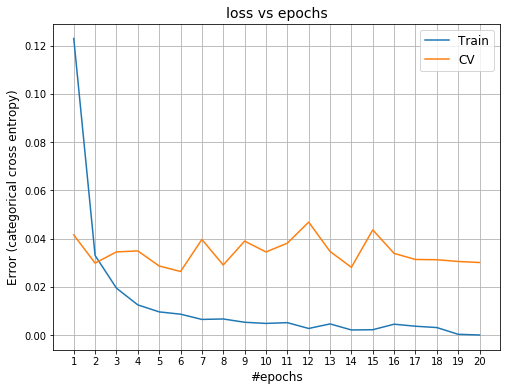

In [21]:
score1_5, train_loss1_5, cv_loss1_5  = report_model(model1_5, history)
table.add_row(['3 ConvNet', 'relu', 'He-normal','None', round(score1_5[0],5), round(score1_5[1],5)])

#### 1.1.2.2 With Batch Normalization + Dropout

In [22]:
model1_6 = Sequential()
#first ConvNet Layer
model1_6.add(Conv2D(16, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1),
                 kernel_initializer = he_normal(seed = None), data_format = 'channels_last'))

#second ConvNet Layer
model1_6.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same',
                kernel_initializer = he_normal(seed = None)))
#adding BatchNomralization layer
model1_6.add(BatchNormalization())
# adding dropout
model1_6.add(Dropout(0.3))

#third ConvNet Layer
model1_6.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same',
                kernel_initializer = he_normal(seed = None)))

# adding MaxPooling
model1_6.add(MaxPooling2D(pool_size = (3,3), padding = 'same', strides = 3)) #by deafult strides pool_size

#flatten
model1_6.add(Flatten())

# fully connected layer: layer-4
model1_6.add(Dense(512, activation = 'relu', kernel_initializer = he_normal(seed = None)))

#output layer
model1_6.add(Dense(num_class, activation = 'softmax', kernel_initializer = he_normal(seed = None)))

model1_6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6400)             

In [23]:
model1_6.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model1_6.fit(X_train, Y_train, validation_data = (X_test,Y_test),epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 16s 259us/step - loss: 12.8789 - acc: 0.1979 - val_loss: 12.9500 - val_acc: 0.1962
Epoch 2/20
60000/60000 [==============================] - 14s 240us/step - loss: 12.8885 - acc: 0.2001 - val_loss: 12.9509 - val_acc: 0.1965
Epoch 3/20
60000/60000 [==============================] - 14s 239us/step - loss: 12.8894 - acc: 0.2001 - val_loss: 12.9467 - val_acc: 0.1967
Epoch 4/20
60000/60000 [==============================] - 14s 240us/step - loss: 12.8911 - acc: 0.2001 - val_loss: 12.9841 - val_acc: 0.1940
Epoch 5/20
60000/60000 [==============================] - 14s 241us/step - loss: 12.8861 - acc: 0.2005 - val_loss: 12.9486 - val_acc: 0.1966
Epoch 6/20
60000/60000 [==============================] - 14s 241us/step - loss: 12.8840 - acc: 0.2006 - val_loss: 12.9526 - val_acc: 0.1963
Epoch 7/20
60000/60000 [==============================] - 14s 240us/step - loss: 12.8857 - acc: 0.2005 -

Test loss:  0.03696046062227506
Test accuracy:  0.9897


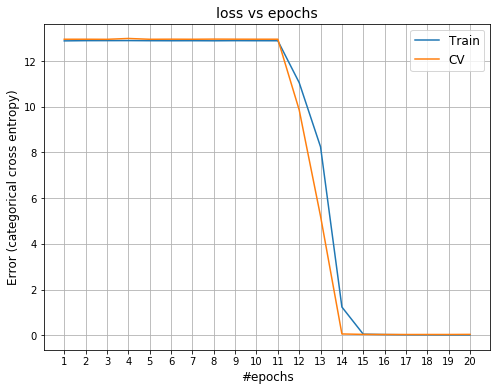

In [24]:
score1_6, train_loss1_6, cv_loss1_6  = report_model(model1_6, history)
table.add_row(['3 ConvNet', 'relu', 'He-normal','BN + Dropout', round(score1_6[0],5), round(score1_6[1],5)])

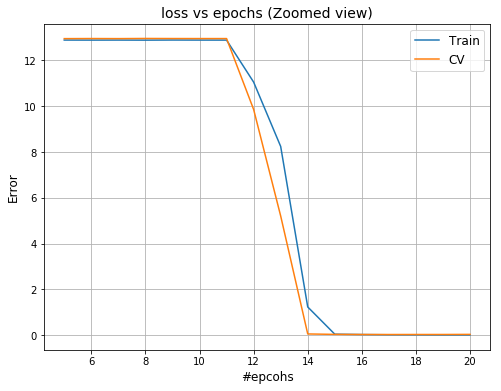

In [25]:
plt.figure(figsize = (8,6))
plt.plot(range(5, 21), train_loss1_6[4:], label = 'Train')
plt.plot(range(5,21), cv_loss1_6[4:], label = 'CV')
plt.title('loss vs epochs (Zoomed view)', fontsize = 14)
plt.xlabel('#epcohs', fontsize = 12)
plt.ylabel('Error', fontsize = 12)
plt.legend(fontsize = 12)
plt.grid(1)
plt.show()

### 1.2.2 Weight Initializer (Glorot-Normal)

#### 1.2.2.1 Without Batch Normalization + Dropout

In [26]:
model1_7 = Sequential()
#first ConvNet Layer
model1_7.add(Conv2D(16, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1),
                 kernel_initializer = glorot_normal(seed = None), data_format = 'channels_last', name = 'Conv2d_1'))

#second ConvNet Layer
model1_7.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same',
                kernel_initializer = glorot_normal(seed = None), name = 'Conv2d_2'))

#third ConvNet Layer
model1_7.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same',
                kernel_initializer = glorot_normal(42), name = 'Conv2d_3'))

# adding MaxPooling
model1_7.add(MaxPooling2D(pool_size = (3,3), padding = 'same', strides = 3, name = 'max_poo_1')) #by deafult strides pool_size

#flatten
model1_7.add(Flatten(name = 'Flatten'))
# fully connected layer: layer-4
model1_7.add(Dense(512, activation = 'relu', kernel_initializer = glorot_normal(seed = None), name = 'FC_1'))

#output layer
model1_7.add(Dense(num_class, activation = 'softmax', kernel_initializer = glorot_normal(seed = None), name = 'Softmax'))

model1_7.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
Conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
Conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_poo_1 (MaxPooling2D)     (None, 10, 10, 64)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
FC_1 (Dense)                 (None, 512)               3277312   
_________________________________________________________________
Softmax (Dense)              (None, 10)               

In [27]:
model1_7.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model1_7.fit(X_train, Y_train, validation_data = (X_test,Y_test),epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 13s 218us/step - loss: 0.1396 - acc: 0.9576 - val_loss: 0.0418 - val_acc: 0.9859
Epoch 2/20
60000/60000 [==============================] - 12s 206us/step - loss: 0.0377 - acc: 0.9881 - val_loss: 0.0357 - val_acc: 0.9878
Epoch 3/20
60000/60000 [==============================] - 12s 202us/step - loss: 0.0242 - acc: 0.9924 - val_loss: 0.0270 - val_acc: 0.9904
Epoch 4/20
60000/60000 [==============================] - 12s 207us/step - loss: 0.0169 - acc: 0.9945 - val_loss: 0.0291 - val_acc: 0.9897
Epoch 5/20
60000/60000 [==============================] - 12s 202us/step - loss: 0.0131 - acc: 0.9960 - val_loss: 0.0268 - val_acc: 0.9912
Epoch 6/20
60000/60000 [==============================] - 12s 203us/step - loss: 0.0097 - acc: 0.9968 - val_loss: 0.0334 - val_acc: 0.9900
Epoch 7/20
60000/60000 [==============================] - 12s 202us/step - loss: 0.0085 - acc: 0.9972 - val_loss: 0.

Test loss:  0.0334581393500604
Test accuracy:  0.9914


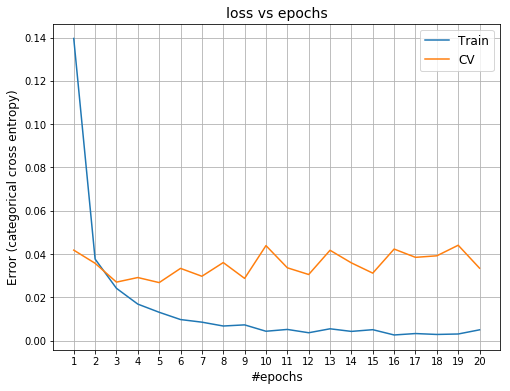

In [28]:
score1_7, train_loss1_7, cv_loss1_7  = report_model(model1_7, history)
table.add_row(['3 ConvNet', 'relu', 'Glorot-normal','None', round(score1_7[0],5), round(score1_7[1],5)])

#### 1.2.2.2 With Batch Normalization + Dropout

In [29]:
model1_8 = Sequential()
#first ConvNet Layer
model1_8.add(Conv2D(16, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1),
                 kernel_initializer = glorot_normal(seed = None), data_format = 'channels_last'))

#second ConvNet Layer
model1_8.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same',
                kernel_initializer = glorot_normal(seed = None)))
#adding BatchNomralization layer
model1_8.add(BatchNormalization())
# adding dropout
model1_8.add(Dropout(0.3))

#third ConvNet Layer
model1_8.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same',
                kernel_initializer = glorot_normal(seed = None)))

# adding MaxPooling
model1_8.add(MaxPooling2D(pool_size = (3,3), padding = 'same', strides = 3)) #by deafult strides pool_size

#flatten
model1_8.add(Flatten())

# fully connected layer: layer-4
model1_8.add(Dense(512, activation = 'relu', kernel_initializer = glorot_normal(seed = None)))

#output layer
model1_8.add(Dense(num_class, activation = 'softmax', kernel_initializer = glorot_normal(seed = None)))

model1_8.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6400)             

In [30]:
model1_8.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model1_8.fit(X_train, Y_train, validation_data = (X_test,Y_test),epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 16s 260us/step - loss: 4.9213 - acc: 0.6390 - val_loss: 0.1594 - val_acc: 0.9516
Epoch 2/20
60000/60000 [==============================] - 15s 242us/step - loss: 0.1079 - acc: 0.9658 - val_loss: 0.0686 - val_acc: 0.9803
Epoch 3/20
60000/60000 [==============================] - 14s 241us/step - loss: 0.0663 - acc: 0.9789 - val_loss: 0.0584 - val_acc: 0.9810
Epoch 4/20
60000/60000 [==============================] - 14s 241us/step - loss: 0.0507 - acc: 0.9841 - val_loss: 0.0445 - val_acc: 0.9859
Epoch 5/20
60000/60000 [==============================] - 15s 242us/step - loss: 0.0394 - acc: 0.9872 - val_loss: 0.0590 - val_acc: 0.9803
Epoch 6/20
60000/60000 [==============================] - 15s 242us/step - loss: 0.0335 - acc: 0.9889 - val_loss: 0.0633 - val_acc: 0.9798
Epoch 7/20
60000/60000 [==============================] - 14s 242us/step - loss: 0.0285 - acc: 0.9906 - val_loss: 0.

Test loss:  0.041962286188453435
Test accuracy:  0.9867


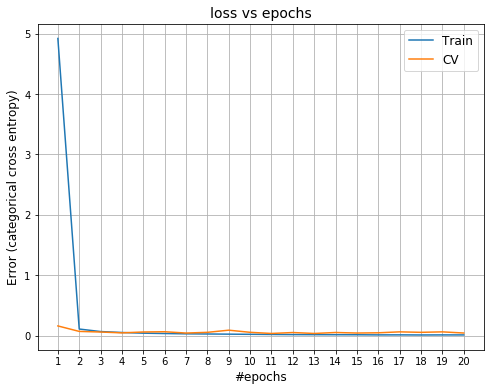

In [31]:
score1_8, train_loss1_8, cv_loss1_8  = report_model(model1_8, history)
table.add_row(['3 ConvNet', 'relu', 'Glorot-normal','BN + Dropout', round(score1_8[0],5), round(score1_8[1],5)])

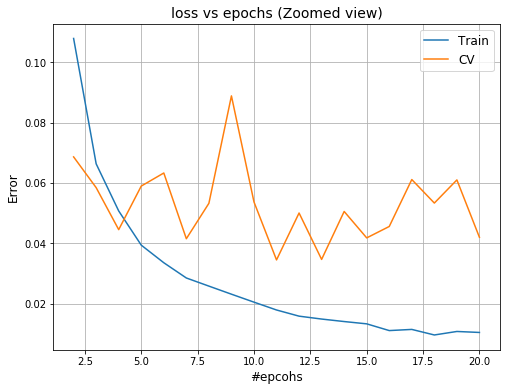

In [32]:
plt.figure(figsize = (8,6))
plt.plot(range(2, 21), train_loss1_8[1:], label = 'Train')
plt.plot(range(2,21), cv_loss1_8[1:], label = 'CV')
plt.title('loss vs epochs (Zoomed view)', fontsize = 14)
plt.xlabel('#epcohs', fontsize = 12)
plt.ylabel('Error', fontsize = 12)
plt.legend(fontsize = 12)
plt.grid(1)
plt.show()

# 2. With 5-Convenet Layer

## 2.1 With *`Tanh`* Activation

**Architecture**
* Without **BN + Dropout**
  * ***input --> 1<sup>st</sup> ConvNet(5,5)16 --> tanh --> 2<sup>nd</sup> ConvNet(5,5)24 --> tanh --> MaxPooling[(2,2),s=2] --> 3 <sup>rd</sup> ConvNet(5,5)40 --> tanh --> 4 <sup>th</sup> ConvNet(5,5)64 --> tanh --> MaxPooling[(2,2), s=2] --> 5 <sup>th</sup> ConveNet(5,5)80 --> tanh --> flatten --> F.C.(720, 'tanh' activation) --> softmax(10)*** 
* With **BN+Dropout**
  * ***input --> 1<sup>st</sup> ConvNet(5,5)16 --> tanh --> Batch Normalization + dropout --> 2<sup>nd</sup> ConvNet(5,5)24 --> tanh --> Batch Normalization + dropout --> MaxPooling[(2,2),s=2] --> 3 <sup>rd</sup> ConvNet(5,5)40 --> tanh --> Batch Normalization + dropout --> 4 <sup>th</sup> ConvNet(5,5)64 --> tanh --> Batch Normalization + dropout --> MaxPooling[(2,2), s=2] --> 5 <sup>th</sup> ConveNet(5,5)80 --> tanh --> Batch Normalization + dropout --> flatten --> F.C.(720, 'tanh' activation) --> softmax(10)***

### 2.1.1 Weight Initializer (He-Normal)

#### 2.1.1.1 Without Batch Normalization + Dropout

In [33]:
model2_1 = Sequential()
#first ConvNet layer
model2_1.add(Conv2D(16, kernel_size = (5,5), activation = 'tanh', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1),name = 'Conv2D_1',
                 kernel_initializer = he_normal(seed = None), data_format = 'channels_last'))

#second ConvNet layer
model2_1.add(Conv2D(24, kernel_size = (5,5), activation = 'tanh', padding = 'same',name = 'Conv2D_2',
                 kernel_initializer = he_normal(seed = None)))

#adding MaxPooling
model2_1.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same', name = 'max_pool_1'))


#third ConvNet layer
model2_1.add(Conv2D(40, kernel_size = (5,5), activation = 'tanh', padding = 'same',name = 'Conv2D_3', 
                kernel_initializer = he_normal(seed = None)))

#fourth ConvNet layer
model2_1.add(Conv2D(64, kernel_size = (5,5), activation = 'tanh', padding = 'same',name = 'Conv2D_4',
                kernel_initializer = he_normal(seed = None)))

#adding MaxPooling
model2_1.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same', name = 'max_pool_2'))

#fifth ConvNet layer
model2_1.add(Conv2D(80, kernel_size = (5,5), activation = 'tanh', padding = 'same', name = 'Conv2D_5', 
                kernel_initializer = he_normal(seed = None)))


#flatted the ConvNet output
model2_1.add(Flatten(name = 'flatten'))
#add dense layer with tanh activations
model2_1.add(Dense(720, activation = 'tanh', kernel_initializer = he_normal(seed = None), name = 'FC_1'))

#add softmax unit
model2_1.add(Dense(num_class, activation = 'softmax', kernel_initializer = he_normal(seed = None), name = 'softmax'))

model2_1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 24)        9624      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 14, 14, 24)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 14, 14, 40)        24040     
_________________________________________________________________
Conv2D_4 (Conv2D)            (None, 14, 14, 64)        64064     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 7, 7, 64)          0         
_________________________________________________________________
Conv2D_5 (Conv2D)            (None, 7, 7, 80)         

In [34]:
model2_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model2_1.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 16s 270us/step - loss: 0.1816 - acc: 0.9530 - val_loss: 0.0532 - val_acc: 0.9837
Epoch 2/20
60000/60000 [==============================] - 15s 242us/step - loss: 0.0421 - acc: 0.9873 - val_loss: 0.0408 - val_acc: 0.9854
Epoch 3/20
60000/60000 [==============================] - 15s 242us/step - loss: 0.0299 - acc: 0.9902 - val_loss: 0.0367 - val_acc: 0.9889
Epoch 4/20
60000/60000 [==============================] - 14s 241us/step - loss: 0.0233 - acc: 0.9922 - val_loss: 0.0297 - val_acc: 0.9903
Epoch 5/20
60000/60000 [==============================] - 15s 243us/step - loss: 0.0201 - acc: 0.9932 - val_loss: 0.0309 - val_acc: 0.9903
Epoch 6/20
60000/60000 [==============================] - 14s 241us/step - loss: 0.0206 - acc: 0.9931 - val_loss: 0.0369 - val_acc: 0.9890
Epoch 7/20
60000/60000 [==============================] - 15s 242us/step - loss: 0.0199 - acc: 0.9934 - val_loss: 0.

Test loss:  0.04523347130485054
Test accuracy:  0.9876


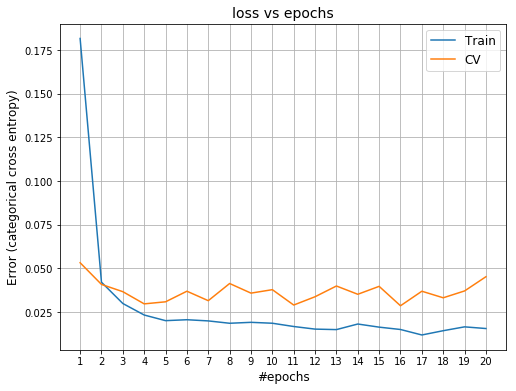

In [35]:
score2_1, train_loss2_1, cv_loss2_1  = report_model(model2_1, history)
table.add_row(['5 ConvNet', 'tanh', 'He-normal','None', round(score2_1[0],5), round(score2_1[1],5)])

#### 2.1.1.2 With Batch Normalization + Dropout

In [36]:
model2_2 = Sequential()
#first ConvNet layer
model2_2.add(Conv2D(16, kernel_size = (5,5), activation = 'tanh', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1), name = 'Conv2D_1',
                 kernel_initializer = he_normal(seed = None), data_format = 'channels_last'))
#adding batch normalization
model2_2.add(BatchNormalization(name = 'BN_1'))
#adding dropout
model2_2.add(Dropout(0.4, name = 'Dropout_1'))


#second ConvNet layer
model2_2.add(Conv2D(24, kernel_size = (5,5), activation = 'tanh', padding = 'same', name = 'Conv2D_2',
                 kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model2_2.add(BatchNormalization(name = 'BN_2'))
#adding dropout
model2_2.add(Dropout(0.4, name = 'Dropout_2'))
#adding MaxPooling
model2_2.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same', name = 'max_pool_1'))


#third ConvNet layer
model2_2.add(Conv2D(40, kernel_size = (5,5), activation = 'tanh', padding = 'same', name = 'Conv2D_3',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model2_2.add(BatchNormalization(name = 'BN_3'))
#adding dropout
model2_2.add(Dropout(0.4, name = 'Dropout_3'))


#fourth ConvNet layer
model2_2.add(Conv2D(64, kernel_size = (5,5), activation = 'tanh', padding = 'same', name = 'Conv2D_4',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model2_2.add(BatchNormalization(name = 'BN_4'))
#adding dropout
model2_2.add(Dropout(0.4, name = 'Dropout_4'))
#adding MaxPooling
model2_2.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same'))

#fifth ConvNet layer
model2_2.add(Conv2D(80, kernel_size = (5,5), activation = 'tanh', padding = 'same', name = 'Conv2D_5',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model2_2.add(BatchNormalization(name = 'BN_5'))
#adding dropout
model2_2.add(Dropout(0.4, name = 'Dropout_5'))
#flatted the ConvNet output
model2_2.add(Flatten(name = 'Flatten'))

#add dense layer with tanh activations
model2_2.add(Dense(720, activation = 'tanh', kernel_initializer = he_normal(seed = None), name = 'FC_1'))

#add softmax unit
model2_2.add(Dense(num_class, activation = 'softmax', kernel_initializer = he_normal(seed = None), name = 'softmax'))

model2_2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 28, 28, 16)        64        
_________________________________________________________________
Dropout_1 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 24)        9624      
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 28, 28, 24)        96        
_________________________________________________________________
Dropout_2 (Dropout)          (None, 28, 28, 24)        0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 14, 14, 24)      

In [37]:
model2_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model2_2.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 23s 381us/step - loss: 0.3724 - acc: 0.8902 - val_loss: 0.2297 - val_acc: 0.9276
Epoch 2/20
60000/60000 [==============================] - 20s 341us/step - loss: 0.1146 - acc: 0.9636 - val_loss: 0.3004 - val_acc: 0.9099
Epoch 3/20
60000/60000 [==============================] - 20s 341us/step - loss: 0.0886 - acc: 0.9715 - val_loss: 0.1730 - val_acc: 0.9453
Epoch 4/20
60000/60000 [==============================] - 20s 341us/step - loss: 0.0770 - acc: 0.9749 - val_loss: 0.1392 - val_acc: 0.9543
Epoch 5/20
60000/60000 [==============================] - 20s 341us/step - loss: 0.0705 - acc: 0.9772 - val_loss: 0.2927 - val_acc: 0.9149
Epoch 6/20
60000/60000 [==============================] - 20s 340us/step - loss: 0.0669 - acc: 0.9793 - val_loss: 0.1748 - val_acc: 0.9477
Epoch 7/20
60000/60000 [==============================] - 20s 340us/step - loss: 0.0634 - acc: 0.9797 - val_loss: 0.

Test loss:  0.5503653975367546
Test accuracy:  0.8662


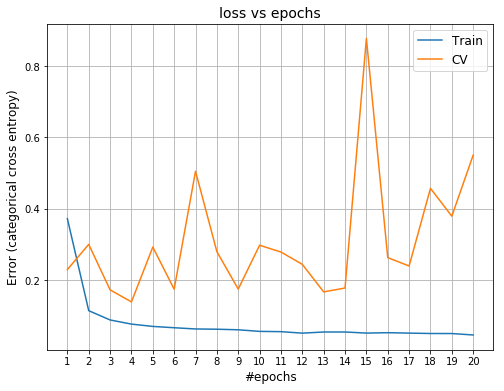

In [38]:
score2_2, train_loss2_2, cv_loss2_2  = report_model(model2_2, history)
table.add_row(['5 ConvNet', 'tanh', 'He-normal','BN + Dropout', round(score2_2[0],5), round(score2_2[1],5)])

### 2.1.2 Weight Initializer (Glorot-Normal)

#### 2.1.2.1 Without Batch Normalization + Dropout

In [39]:
model2_3 = Sequential()
#first ConvNet layer
model2_3.add(Conv2D(16, kernel_size = (5,5), activation = 'tanh', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1),name = 'Conv2D_1',
                 kernel_initializer = glorot_normal(seed = None), data_format = 'channels_last'))

#second ConvNet layer
model2_3.add(Conv2D(24, kernel_size = (5,5), activation = 'tanh', padding = 'same',name = 'Conv2D_2',
                 kernel_initializer = glorot_normal(seed = None)))

#adding MaxPooling
model2_3.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same', name = 'max_pool_1'))


#third ConvNet layer
model2_3.add(Conv2D(40, kernel_size = (5,5), activation = 'tanh', padding = 'same',name = 'Conv2D_3', 
                kernel_initializer = glorot_normal(seed = None)))

#fourth ConvNet layer
model2_3.add(Conv2D(64, kernel_size = (5,5), activation = 'tanh', padding = 'same',name = 'Conv2D_4',
                kernel_initializer = glorot_normal(seed = None)))

#adding MaxPooling
model2_3.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same', name = 'max_pool_2'))

#fifth ConvNet layer
model2_3.add(Conv2D(80, kernel_size = (5,5), activation = 'tanh', padding = 'same', name = 'Conv2D_5', 
                kernel_initializer = glorot_normal(seed = None)))


#flatted the ConvNet output
model2_3.add(Flatten(name = 'flatten'))
#add dense layer with tanh activations
model2_3.add(Dense(720, activation = 'tanh', kernel_initializer = glorot_normal(seed = None), name = 'FC_1'))

#add softmax unit
model2_3.add(Dense(num_class, activation = 'softmax', kernel_initializer = glorot_normal(seed = None), name = 'softmax'))

model2_3.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 24)        9624      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 14, 14, 24)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 14, 14, 40)        24040     
_________________________________________________________________
Conv2D_4 (Conv2D)            (None, 14, 14, 64)        64064     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 7, 7, 64)          0         
_________________________________________________________________
Conv2D_5 (Conv2D)            (None, 7, 7, 80)        

In [40]:
model2_3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model2_3.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 16s 268us/step - loss: 0.1558 - acc: 0.9538 - val_loss: 0.0457 - val_acc: 0.9852
Epoch 2/20
60000/60000 [==============================] - 14s 241us/step - loss: 0.0480 - acc: 0.9851 - val_loss: 0.0364 - val_acc: 0.9881
Epoch 3/20
60000/60000 [==============================] - 14s 240us/step - loss: 0.0336 - acc: 0.9896 - val_loss: 0.0331 - val_acc: 0.9891
Epoch 4/20
60000/60000 [==============================] - 15s 242us/step - loss: 0.0285 - acc: 0.9909 - val_loss: 0.0395 - val_acc: 0.9862
Epoch 5/20
60000/60000 [==============================] - 14s 240us/step - loss: 0.0254 - acc: 0.9919 - val_loss: 0.0347 - val_acc: 0.9873
Epoch 6/20
60000/60000 [==============================] - 14s 239us/step - loss: 0.0226 - acc: 0.9925 - val_loss: 0.0388 - val_acc: 0.9875
Epoch 7/20
60000/60000 [==============================] - 14s 240us/step - loss: 0.0232 - acc: 0.9923 - val_loss: 0.

Test loss:  0.03522461337227796
Test accuracy:  0.9901


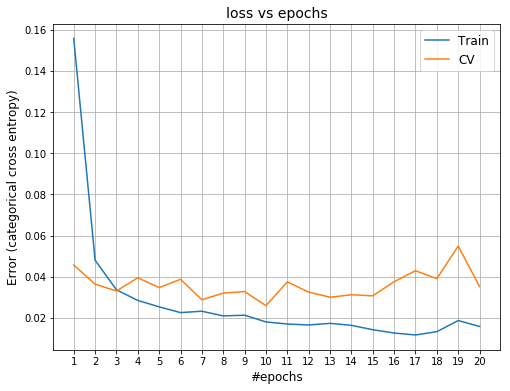

In [41]:
score2_3, train_loss2_3, cv_loss2_3  = report_model(model2_3, history)
table.add_row(['5 ConvNet', 'tanh', 'Glorot-normal','None', round(score2_3[0],5), round(score2_3[1],5)])

#### 2.1.2.2 With Batch Normalization + Dropout

In [42]:
model2_4 = Sequential()
#first ConvNet layer
model2_4.add(Conv2D(16, kernel_size = (5,5), activation = 'tanh', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1), name = 'Conv2D_1',
                 kernel_initializer = glorot_normal(seed = None), data_format = 'channels_last'))
#adding batch normalization
model2_4.add(BatchNormalization(name = 'BN_1'))
#adding dropout
model2_4.add(Dropout(0.4, name = 'Dropout_1'))


#second ConvNet layer
model2_4.add(Conv2D(24, kernel_size = (5,5), activation = 'tanh', padding = 'same', name = 'Conv2D_2',
                 kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model2_4.add(BatchNormalization(name = 'BN_2'))
#adding dropout
model2_4.add(Dropout(0.4, name = 'Dropout_2'))
#adding MaxPooling
model2_4.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same', name = 'max_pool_1'))


#third ConvNet layer
model2_4.add(Conv2D(40, kernel_size = (5,5), activation = 'tanh', padding = 'same', name = 'Conv2D_3',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model2_4.add(BatchNormalization(name = 'BN_3'))
#adding dropout
model2_4.add(Dropout(0.4, name = 'Dropout_3'))


#fourth ConvNet layer
model2_4.add(Conv2D(64, kernel_size = (5,5), activation = 'tanh', padding = 'same', name = 'Conv2D_4',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model2_4.add(BatchNormalization(name = 'BN_4'))
#adding dropout
model2_4.add(Dropout(0.4, name = 'Dropout_4'))
#adding MaxPooling
model2_4.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same'))

#fifth ConvNet layer
model2_4.add(Conv2D(80, kernel_size = (5,5), activation = 'tanh', padding = 'same', name = 'Conv2D_5',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model2_4.add(BatchNormalization(name = 'BN_5'))
#adding dropout
model2_4.add(Dropout(0.4, name = 'Dropout_5'))
#flatted the ConvNet output
model2_4.add(Flatten(name = 'Flatten'))

#add dense layer with tanh activations
model2_4.add(Dense(720, activation = 'tanh', kernel_initializer = glorot_normal(seed = None), name = 'FC_1'))

#add softmax unit
model2_4.add(Dense(num_class, activation = 'softmax', kernel_initializer = glorot_normal(seed = None), name = 'softmax'))

model2_4.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 28, 28, 16)        64        
_________________________________________________________________
Dropout_1 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 24)        9624      
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 28, 28, 24)        96        
_________________________________________________________________
Dropout_2 (Dropout)          (None, 28, 28, 24)        0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 14, 14, 24)      

In [43]:
model2_4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model2_4.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 23s 386us/step - loss: 0.3021 - acc: 0.9142 - val_loss: 0.1139 - val_acc: 0.9630
Epoch 2/20
60000/60000 [==============================] - 20s 341us/step - loss: 0.0945 - acc: 0.9701 - val_loss: 0.1220 - val_acc: 0.9615
Epoch 3/20
60000/60000 [==============================] - 20s 341us/step - loss: 0.0729 - acc: 0.9769 - val_loss: 0.1721 - val_acc: 0.9456
Epoch 4/20
60000/60000 [==============================] - 20s 341us/step - loss: 0.0646 - acc: 0.9792 - val_loss: 0.1971 - val_acc: 0.9406
Epoch 5/20
60000/60000 [==============================] - 20s 341us/step - loss: 0.0623 - acc: 0.9806 - val_loss: 0.5525 - val_acc: 0.8475
Epoch 6/20
60000/60000 [==============================] - 20s 341us/step - loss: 0.0603 - acc: 0.9809 - val_loss: 0.2827 - val_acc: 0.9237
Epoch 7/20
60000/60000 [==============================] - 20s 340us/step - loss: 0.0602 - acc: 0.9813 - val_loss: 0.

Test loss:  0.4148712014615536
Test accuracy:  0.9023


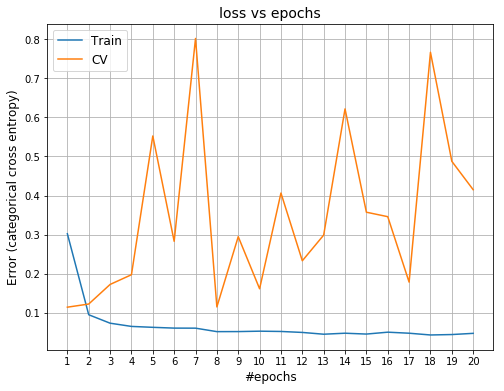

In [44]:
score2_4, train_loss2_4, cv_loss2_4  = report_model(model2_4, history)
table.add_row(['5 ConvNet', 'tanh', 'Glorot-normal','BN + Dropout', round(score2_4[0],5), round(score2_4[1],5)])

## 2.2 With *`ReLU`* Activation

**Architecture**
* Without **BN + Dropout**
  * ***input --> 1<sup>st</sup> ConvNet(5,5)16 --> relu --> 2<sup>nd</sup> ConvNet(5,5)24 --> relu --> MaxPooling[(2,2),s=2] --> 3 <sup>rd</sup> ConvNet(5,5)40 --> relu --> 4 <sup>th</sup> ConvNet(5,5)64 --> relu --> MaxPooling[(2,2), s=2] --> 5 <sup>th</sup> ConveNet(5,5)80 --> relu --> flatten --> F.C.(720, 'relu' activation) --> softmax(10)*** 
* With **BN+Dropout**
  * ***input --> 1<sup>st</sup> ConvNet(5,5)16 --> relu --> Batch Normalization + dropout --> 2<sup>nd</sup> ConvNet(5,5)24 --> relu --> Batch Normalization + dropout --> MaxPooling[(2,2),s=2] --> 3 <sup>rd</sup> ConvNet(5,5)40 --> relu --> Batch Normalization + dropout --> 4 <sup>th</sup> ConvNet(5,5)64 --> relu --> Batch Normalization + dropout --> MaxPooling[(2,2), s=2] --> 5 <sup>th</sup> ConveNet(5,5)80 --> relu --> Batch Normalization + dropout --> flatten --> F.C.(720, 'relu' activation) --> softmax(10)***

### 2.2.1 Weight Initializer (He-Normal)

#### 2.1.2.1 Without Batch Normalization + Dropout

In [45]:
model2_5 = Sequential()
#first ConvNet layer
model2_5.add(Conv2D(16, kernel_size = (5,5), activation = 'relu', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1),name = 'Conv2D_1',
                 kernel_initializer = he_normal(seed = None), data_format = 'channels_last'))

#second ConvNet layer
model2_5.add(Conv2D(24, kernel_size = (5,5), activation = 'relu', padding = 'same',name = 'Conv2D_2',
                 kernel_initializer = he_normal(seed = None)))

#adding MaxPooling
model2_5.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same', name = 'max_pool_1'))


#third ConvNet layer
model2_5.add(Conv2D(40, kernel_size = (5,5), activation = 'relu', padding = 'same',name = 'Conv2D_3', 
                kernel_initializer = he_normal(seed = None)))

#fourth ConvNet layer
model2_5.add(Conv2D(64, kernel_size = (5,5), activation = 'relu', padding = 'same',name = 'Conv2D_4',
                kernel_initializer = he_normal(seed = None)))

#adding MaxPooling
model2_5.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same', name = 'max_pool_2'))

#fifth ConvNet layer
model2_5.add(Conv2D(80, kernel_size = (5,5), activation = 'relu', padding = 'same', name = 'Conv2D_5', 
                kernel_initializer = he_normal(seed = None)))


#flatted the ConvNet output
model2_5.add(Flatten(name = 'flatten'))
#add dense layer with relu activations
model2_5.add(Dense(720, activation = 'relu', kernel_initializer = he_normal(seed = None), name = 'FC_1'))

#add softmax unit
model2_5.add(Dense(num_class, activation = 'softmax', kernel_initializer = he_normal(seed = None), name = 'softmax'))

model2_5.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 24)        9624      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 14, 14, 24)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 14, 14, 40)        24040     
_________________________________________________________________
Conv2D_4 (Conv2D)            (None, 14, 14, 64)        64064     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 7, 7, 64)          0         
_________________________________________________________________
Conv2D_5 (Conv2D)            (None, 7, 7, 80)        

In [46]:
model2_5.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model2_5.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 16s 274us/step - loss: 0.1643 - acc: 0.9505 - val_loss: 0.0333 - val_acc: 0.9898
Epoch 2/20
60000/60000 [==============================] - 14s 240us/step - loss: 0.0371 - acc: 0.9886 - val_loss: 0.0266 - val_acc: 0.9912
Epoch 3/20
60000/60000 [==============================] - 14s 238us/step - loss: 0.0263 - acc: 0.9917 - val_loss: 0.0252 - val_acc: 0.9922
Epoch 4/20
60000/60000 [==============================] - 14s 239us/step - loss: 0.0205 - acc: 0.9933 - val_loss: 0.0317 - val_acc: 0.9895
Epoch 5/20
60000/60000 [==============================] - 14s 240us/step - loss: 0.0171 - acc: 0.9943 - val_loss: 0.0253 - val_acc: 0.9923
Epoch 6/20
60000/60000 [==============================] - 14s 241us/step - loss: 0.0149 - acc: 0.9952 - val_loss: 0.0308 - val_acc: 0.9915
Epoch 7/20
60000/60000 [==============================] - 14s 238us/step - loss: 0.0134 - acc: 0.9958 - val_loss: 0.

Test loss:  0.031246501042114776
Test accuracy:  0.9934


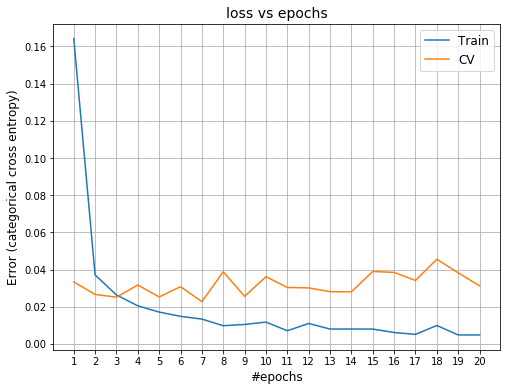

In [47]:
score2_5, train_loss2_5, cv_loss2_2  = report_model(model2_5, history)
table.add_row(['5 ConvNet', 'relu', 'He-normal','None', round(score2_5[0],5), round(score2_5[1],5)])

#### 2.1.2.2 With Batch Normalization + Dropout

In [48]:
model2_6 = Sequential()
#first ConvNet layer
model2_6.add(Conv2D(16, kernel_size = (5,5), activation = 'relu', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1), name = 'Conv2D_1',
                 kernel_initializer = he_normal(seed = None), data_format = 'channels_last'))
#adding batch normalization
model2_6.add(BatchNormalization(name = 'BN_1'))
#adding dropout
model2_6.add(Dropout(0.4, name = 'Dropout_1'))


#second ConvNet layer
model2_6.add(Conv2D(24, kernel_size = (5,5), activation = 'relu', padding = 'same', name = 'Conv2D_2',
                 kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model2_6.add(BatchNormalization(name = 'BN_2'))
#adding dropout
model2_6.add(Dropout(0.4, name = 'Dropout_2'))
#adding MaxPooling
model2_6.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same', name = 'max_pool_1'))


#third ConvNet layer
model2_6.add(Conv2D(40, kernel_size = (5,5), activation = 'relu', padding = 'same', name = 'Conv2D_3',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model2_6.add(BatchNormalization(name = 'BN_3'))
#adding dropout
model2_6.add(Dropout(0.4, name = 'Dropout_3'))


#fourth ConvNet layer
model2_6.add(Conv2D(64, kernel_size = (5,5), activation = 'relu', padding = 'same', name = 'Conv2D_4',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model2_6.add(BatchNormalization(name = 'BN_4'))
#adding dropout
model2_6.add(Dropout(0.4, name = 'Dropout_4'))
#adding MaxPooling
model2_6.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same'))

#fifth ConvNet layer
model2_6.add(Conv2D(80, kernel_size = (5,5), activation = 'relu', padding = 'same', name = 'Conv2D_5',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model2_6.add(BatchNormalization(name = 'BN_5'))
#adding dropout
model2_6.add(Dropout(0.4, name = 'Dropout_5'))
#flatted the ConvNet output
model2_6.add(Flatten(name = 'Flatten'))

#add dense layer with relu activations
model2_6.add(Dense(720, activation = 'relu', kernel_initializer = he_normal(seed = None), name = 'FC_1'))

#add softmax unit
model2_6.add(Dense(num_class, activation = 'softmax', kernel_initializer = he_normal(seed = None), name = 'softmax'))

model2_6.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 28, 28, 16)        64        
_________________________________________________________________
Dropout_1 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 24)        9624      
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 28, 28, 24)        96        
_________________________________________________________________
Dropout_2 (Dropout)          (None, 28, 28, 24)        0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 14, 14, 24)      

In [49]:
model2_6.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model2_6.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 24s 400us/step - loss: 0.2280 - acc: 0.9324 - val_loss: 0.0728 - val_acc: 0.9747
Epoch 2/20
60000/60000 [==============================] - 21s 344us/step - loss: 0.0793 - acc: 0.9759 - val_loss: 0.0461 - val_acc: 0.9837
Epoch 3/20
60000/60000 [==============================] - 21s 345us/step - loss: 0.0594 - acc: 0.9817 - val_loss: 0.0460 - val_acc: 0.9848
Epoch 4/20
60000/60000 [==============================] - 21s 344us/step - loss: 0.0460 - acc: 0.9861 - val_loss: 0.0434 - val_acc: 0.9853
Epoch 5/20
60000/60000 [==============================] - 21s 347us/step - loss: 0.0438 - acc: 0.9866 - val_loss: 0.0425 - val_acc: 0.9865
Epoch 6/20
60000/60000 [==============================] - 21s 344us/step - loss: 0.0378 - acc: 0.9882 - val_loss: 0.0326 - val_acc: 0.9892
Epoch 7/20
60000/60000 [==============================] - 21s 345us/step - loss: 0.0335 - acc: 0.9900 - val_loss: 0.

Test loss:  0.035018609793759495
Test accuracy:  0.9926


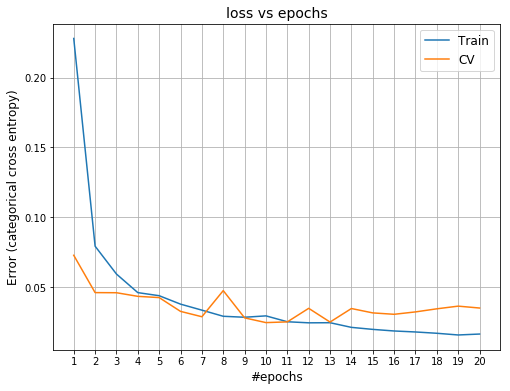

In [50]:
score2_6, train_loss2_6, cv_loss2_6  = report_model(model2_6, history)
table.add_row(['5 ConvNet', 'relu', 'He-normal','BN + Dropout', round(score2_6[0],5), round(score2_6[1],5)])

### 2.2.2 Weight Initializer (Glorot-Normal)

#### 2.2.2.1 Without Batch Normalization + Dropout

In [51]:
model2_7 = Sequential()
#first ConvNet layer
model2_7.add(Conv2D(16, kernel_size = (5,5), activation = 'relu', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1),name = 'Conv2D_1',
                 kernel_initializer = glorot_normal(seed = None), data_format = 'channels_last'))

#second ConvNet layer
model2_7.add(Conv2D(24, kernel_size = (5,5), activation = 'relu', padding = 'same',name = 'Conv2D_2',
                 kernel_initializer = glorot_normal(seed = None)))

#adding MaxPooling
model2_7.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same', name = 'max_pool_1'))


#third ConvNet layer
model2_7.add(Conv2D(40, kernel_size = (5,5), activation = 'relu', padding = 'same',name = 'Conv2D_3', 
                kernel_initializer = glorot_normal(seed = None)))

#fourth ConvNet layer
model2_7.add(Conv2D(64, kernel_size = (5,5), activation = 'relu', padding = 'same',name = 'Conv2D_4',
                kernel_initializer = glorot_normal(seed = None)))

#adding MaxPooling
model2_7.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same', name = 'max_pool_2'))

#fifth ConvNet layer
model2_7.add(Conv2D(80, kernel_size = (5,5), activation = 'relu', padding = 'same', name = 'Conv2D_5', 
                kernel_initializer = glorot_normal(seed = None)))


#flatted the ConvNet output
model2_7.add(Flatten(name = 'flatten'))
#add dense layer with relu activations
model2_7.add(Dense(720, activation = 'relu', kernel_initializer = glorot_normal(seed = None), name = 'FC_1'))

#add softmax unit
model2_7.add(Dense(num_class, activation = 'softmax', kernel_initializer = glorot_normal(seed = None), name = 'softmax'))

model2_7.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 24)        9624      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 14, 14, 24)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 14, 14, 40)        24040     
_________________________________________________________________
Conv2D_4 (Conv2D)            (None, 14, 14, 64)        64064     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 7, 7, 64)          0         
_________________________________________________________________
Conv2D_5 (Conv2D)            (None, 7, 7, 80)        

In [52]:
model2_7.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model2_7.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 17s 291us/step - loss: 0.1438 - acc: 0.9550 - val_loss: 0.0335 - val_acc: 0.9881
Epoch 2/20
60000/60000 [==============================] - 15s 242us/step - loss: 0.0396 - acc: 0.9876 - val_loss: 0.0421 - val_acc: 0.9862
Epoch 3/20
60000/60000 [==============================] - 14s 240us/step - loss: 0.0253 - acc: 0.9920 - val_loss: 0.0284 - val_acc: 0.9907
Epoch 4/20
60000/60000 [==============================] - 14s 240us/step - loss: 0.0203 - acc: 0.9939 - val_loss: 0.0415 - val_acc: 0.9881
Epoch 5/20
60000/60000 [==============================] - 14s 241us/step - loss: 0.0180 - acc: 0.9947 - val_loss: 0.0207 - val_acc: 0.9927
Epoch 6/20
60000/60000 [==============================] - 14s 239us/step - loss: 0.0148 - acc: 0.9953 - val_loss: 0.0263 - val_acc: 0.9922
Epoch 7/20
60000/60000 [==============================] - 15s 247us/step - loss: 0.0132 - acc: 0.9959 - val_loss: 0.

Test loss:  0.03921086723458029
Test accuracy:  0.9911


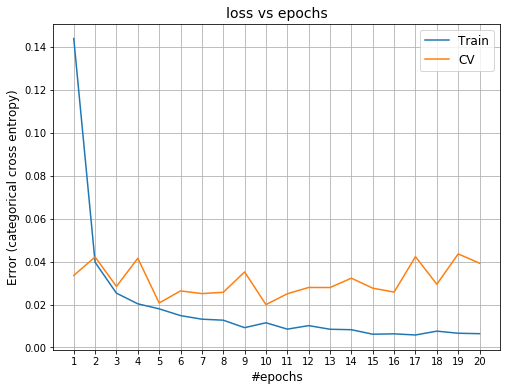

In [53]:
score2_7, train_loss2_7, cv_loss2_7  = report_model(model2_7, history)
table.add_row(['5 ConvNet', 'ReLU', 'Glorot-normal','None', round(score2_7[0],5), round(score2_7[1],5)])

#### 2.2.2.2 With Batch Normalization + Dropout

In [54]:
model2_8 = Sequential()
#first ConvNet layer
model2_8.add(Conv2D(16, kernel_size = (5,5), activation = 'relu', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1), name = 'Conv2D_1',
                 kernel_initializer = glorot_normal(seed = None), data_format = 'channels_last'))
#adding batch normalization
model2_8.add(BatchNormalization(name = 'BN_1'))
#adding dropout
model2_8.add(Dropout(0.4, name = 'Dropout_1'))


#second ConvNet layer
model2_8.add(Conv2D(24, kernel_size = (5,5), activation = 'relu', padding = 'same', name = 'Conv2D_2',
                 kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model2_8.add(BatchNormalization(name = 'BN_2'))
#adding dropout
model2_8.add(Dropout(0.4, name = 'Dropout_2'))
#adding MaxPooling
model2_8.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same', name = 'max_pool_1'))


#third ConvNet layer
model2_8.add(Conv2D(40, kernel_size = (5,5), activation = 'relu', padding = 'same', name = 'Conv2D_3',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model2_8.add(BatchNormalization(name = 'BN_3'))
#adding dropout
model2_8.add(Dropout(0.4, name = 'Dropout_3'))


#fourth ConvNet layer
model2_8.add(Conv2D(64, kernel_size = (5,5), activation = 'relu', padding = 'same', name = 'Conv2D_4',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model2_8.add(BatchNormalization(name = 'BN_4'))
#adding dropout
model2_8.add(Dropout(0.4, name = 'Dropout_4'))
#adding MaxPooling
model2_8.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same'))

#fifth ConvNet layer
model2_8.add(Conv2D(80, kernel_size = (5,5), activation = 'relu', padding = 'same', name = 'Conv2D_5',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model2_8.add(BatchNormalization(name = 'BN_5'))
#adding dropout
model2_8.add(Dropout(0.4, name = 'Dropout_5'))
#flatted the ConvNet output
model2_8.add(Flatten(name = 'Flatten'))

#add dense layer with relu activations
model2_8.add(Dense(720, activation = 'relu', kernel_initializer = glorot_normal(seed = None), name = 'FC_1'))

#add softmax unit
model2_8.add(Dense(num_class, activation = 'softmax', kernel_initializer = glorot_normal(seed = None), name = 'softmax'))

model2_8.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 28, 28, 16)        64        
_________________________________________________________________
Dropout_1 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 24)        9624      
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 28, 28, 24)        96        
_________________________________________________________________
Dropout_2 (Dropout)          (None, 28, 28, 24)        0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 14, 14, 24)      

In [55]:
model2_8.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model2_8.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 25s 411us/step - loss: 0.2179 - acc: 0.9365 - val_loss: 0.1777 - val_acc: 0.9458
Epoch 2/20
60000/60000 [==============================] - 21s 348us/step - loss: 0.0701 - acc: 0.9787 - val_loss: 0.0782 - val_acc: 0.9760
Epoch 3/20
60000/60000 [==============================] - 21s 348us/step - loss: 0.0508 - acc: 0.9845 - val_loss: 0.0446 - val_acc: 0.9866
Epoch 4/20
60000/60000 [==============================] - 21s 346us/step - loss: 0.0456 - acc: 0.9861 - val_loss: 0.0547 - val_acc: 0.9834
Epoch 5/20
60000/60000 [==============================] - 21s 346us/step - loss: 0.0392 - acc: 0.9879 - val_loss: 0.0510 - val_acc: 0.9847
Epoch 6/20
60000/60000 [==============================] - 21s 348us/step - loss: 0.0352 - acc: 0.9895 - val_loss: 0.0677 - val_acc: 0.9819
Epoch 7/20
60000/60000 [==============================] - 21s 347us/step - loss: 0.0326 - acc: 0.9899 - val_loss: 0.

Test loss:  0.0587219970022456
Test accuracy:  0.9896


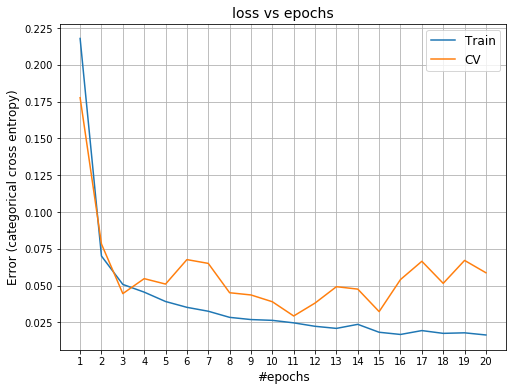

In [56]:
score2_8, train_loss2_8, cv_loss2_8  = report_model(model2_8, history)
table.add_row(['5 ConvNet', 'ReLU', 'Glorot-normal','BN + Dropout', round(score2_8[0],5), round(score2_8[1],5)])

# 3. With 7-ConvNet Layer

## 3.1 With *`Tanh`* Activation

**Architecture**
* Without **BN + Dropout**
  * ***input --> 1<sup>st</sup> ConvNet(7,7)24 --> tanh -->  2<sup>nd</sup> ConvNet(7,7)50 --> tanh -->  3<sup>rd</sup> ConvNet(7,7)70 --> tanh -->  MaxPool[(5,5),s=5] --> 4<sup>th</sup> ConvNet(7,7)90 --> tanh -->  5<sup>th</sup> ConvNet(7,7)100 --> tanh -->  6<sup>th</sup> ConvNet(7,7)110 --> tanh -->  MaxPool[(5,5),s=5] --> 7<sup>th</sup> ConvNet(7,7)130 -->  flatten --> F.C.(260) --> softmax(10)***
* With **BN + Dropout**
  * ***input --> 1<sup>st</sup> ConvNet(7,7)24 --> tanh --> Batch Nomralization+dropout --> 2<sup>nd</sup> ConvNet(7,7)50 --> tanh --> Batch Nomralization+dropout --> 3<sup>rd</sup> ConvNet(7,7)70 --> tanh --> Batch Nomralization+dropout --> MaxPool[(5,5),s=5] --> 4<sup>th</sup> ConvNet(7,7)90 --> tanh --> Batch Nomralization+dropout --> 5<sup>th</sup> ConvNet(7,7)100 --> tanh --> Batch Nomralization+dropout --> 6<sup>th</sup> ConvNet(7,7)110 --> tanh --> Batch Nomralization+dropout --> MaxPool[(5,5),s=5] --> 7<sup>th</sup> ConvNet(7,7)130 --> Batch Nomralization+dropout --> flatten --> F.C.(260) --> softmax(10)***

### 3.1.1 Weight Initializer (He-Normal)

#### 3.1.1.1 Without Batch Normalization + Dropout

In [57]:
model3_1 = Sequential()
#first ConvNet layer
model3_1.add(Conv2D(24, kernel_size = (7,7), activation = 'tanh', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1), name = 'Conv2D_1',
                 kernel_initializer = he_normal(seed = None), data_format = 'channels_last'))

#second ConvNet layer
model3_1.add(Conv2D(50, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_2',
                 kernel_initializer = he_normal(seed = None)))

#third ConvNet layer
model3_1.add(Conv2D(70, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_3',
                kernel_initializer = he_normal(seed = None)))

#adding MaxPooling
model3_1.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_1'))


#fourth ConvNet layer
model3_1.add(Conv2D(90, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_4',
                kernel_initializer = he_normal(seed = None)))

#fifth ConvNet layer
model3_1.add(Conv2D(100, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_5',
                kernel_initializer = he_normal(seed = None)))

#sixth ConvNet layer
model3_1.add(Conv2D(110, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_6',
                kernel_initializer = he_normal(seed = None)))

#adding MaxPooling
model3_1.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_2'))


#seventh ConvNet layer
model3_1.add(Conv2D(130, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_7',
                kernel_initializer = he_normal(seed = None)))

#flatted the ConvNet output
model3_1.add(Flatten(name = 'Flatten_1'))

#add dense layer with tanh activations
model3_1.add(Dense(260, activation = 'tanh', kernel_initializer = he_normal(seed = None), name = 'FC_1'))

#add softmax unit
model3_1.add(Dense(num_class, activation = 'softmax', kernel_initializer = he_normal(seed = None), name = 'softmax'))

model3_1.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 24)        1200      
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 50)        58850     
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 28, 28, 70)        171570    
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 6, 6, 70)          0         
_________________________________________________________________
Conv2D_4 (Conv2D)            (None, 6, 6, 90)          308790    
_________________________________________________________________
Conv2D_5 (Conv2D)            (None, 6, 6, 100)         441100    
_________________________________________________________________
Conv2D_6 (Conv2D)            (None, 6, 6, 110)       

In [58]:
model3_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model3_1.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 54s 899us/step - loss: 0.2897 - acc: 0.9098 - val_loss: 0.0936 - val_acc: 0.9719
Epoch 2/20
60000/60000 [==============================] - 49s 815us/step - loss: 0.0688 - acc: 0.9792 - val_loss: 0.0432 - val_acc: 0.9868
Epoch 3/20
60000/60000 [==============================] - 49s 815us/step - loss: 0.0548 - acc: 0.9838 - val_loss: 0.0403 - val_acc: 0.9879
Epoch 4/20
60000/60000 [==============================] - 49s 814us/step - loss: 0.0465 - acc: 0.9863 - val_loss: 0.0410 - val_acc: 0.9884
Epoch 5/20
60000/60000 [==============================] - 49s 817us/step - loss: 0.0434 - acc: 0.9872 - val_loss: 0.0547 - val_acc: 0.9856
Epoch 6/20
60000/60000 [==============================] - 49s 817us/step - loss: 0.0409 - acc: 0.9872 - val_loss: 0.0407 - val_acc: 0.9881
Epoch 7/20
60000/60000 [==============================] - 49s 816us/step - loss: 0.0392 - acc: 0.9880 - val_loss: 0.

Test loss:  0.03996596260825172
Test accuracy:  0.9883


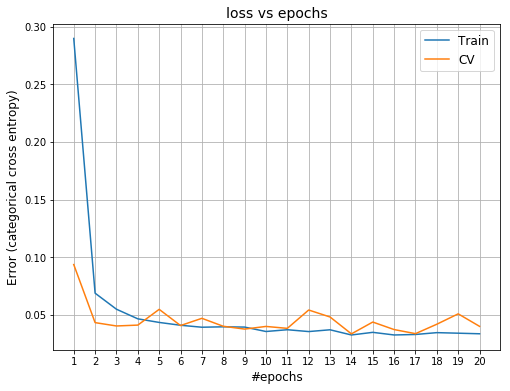

In [59]:
score3_1, train_loss3_1, cv_loss3_1  = report_model(model3_1, history)
table.add_row(['7 ConvNet', 'tanh', 'He-normal','None', round(score3_1[0],5), round(score3_1[1],5)])

#### 3.1.1.2 With Batch Normalization + Dropout

In [60]:
model3_2 = Sequential()
#first ConvNet layer
model3_2.add(Conv2D(24, kernel_size = (7,7), activation = 'tanh', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1), name = 'Conv2D_1',
                 kernel_initializer = he_normal(seed = None), data_format = 'channels_last'))
#adding batch normalization
model3_2.add(BatchNormalization(name = 'BN_1'))
#adding dropout
model3_2.add(Dropout(0.5, name = 'Dropout_1'))


#second ConvNet layer
model3_2.add(Conv2D(50, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_2',
                 kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model3_2.add(BatchNormalization(name = 'BN_2'))
#adding dropout
model3_2.add(Dropout(0.5, name = 'Dropout_2'))


#third ConvNet layer
model3_2.add(Conv2D(70, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_3',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model3_2.add(BatchNormalization(name = 'BN_3'))
#adding dropout
model3_2.add(Dropout(0.5, name = 'Dropout_3'))
#adding MaxPooling
model3_2.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_1'))


#fourth ConvNet layer
model3_2.add(Conv2D(90, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_4',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model3_2.add(BatchNormalization(name = 'BN_4'))
#adding dropout
model3_2.add(Dropout(0.5, name = 'Dropout_4'))


#fifth ConvNet layer
model3_2.add(Conv2D(100, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_5',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model3_2.add(BatchNormalization(name = 'BN_5'))
#adding dropout
model3_2.add(Dropout(0.5, name = 'Dropout_5'))


#sixth ConvNet layer
model3_2.add(Conv2D(110, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_6',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model3_2.add(BatchNormalization(name = 'BN_6'))
#adding dropout
model3_2.add(Dropout(0.5, name = 'Dropout_6'))
#adding MaxPooling
model3_2.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_2'))


#seventh ConvNet layer
model3_2.add(Conv2D(130, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_7',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model3_2.add(BatchNormalization(name = 'BN_7'))
#adding dropout
model3_2.add(Dropout(0.5, name = 'Dropout_7'))

#flatted the ConvNet output
model3_2.add(Flatten(name = 'Flatten_1'))


#add dense layer with tanh activations
model3_2.add(Dense(260, activation = 'tanh', kernel_initializer = he_normal(seed = None), name = 'FC_1'))

#add softmax unit
model3_2.add(Dense(num_class, activation = 'softmax', kernel_initializer = he_normal(seed = None), name = 'softmax'))

model3_2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 24)        1200      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 28, 28, 24)        96        
_________________________________________________________________
Dropout_1 (Dropout)          (None, 28, 28, 24)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 50)        58850     
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 28, 28, 50)        200       
_________________________________________________________________
Dropout_2 (Dropout)          (None, 28, 28, 50)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 28, 28, 70)      

In [61]:
model3_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model3_2.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 66s 1ms/step - loss: 1.9716 - acc: 0.2389 - val_loss: 1.8994 - val_acc: 0.3679
Epoch 2/20
60000/60000 [==============================] - 61s 1ms/step - loss: 0.5551 - acc: 0.8210 - val_loss: 0.6438 - val_acc: 0.8394
Epoch 3/20
60000/60000 [==============================] - 61s 1ms/step - loss: 0.2918 - acc: 0.9153 - val_loss: 0.5686 - val_acc: 0.8656
Epoch 4/20
60000/60000 [==============================] - 61s 1ms/step - loss: 0.2398 - acc: 0.9290 - val_loss: 0.4254 - val_acc: 0.8944
Epoch 5/20
60000/60000 [==============================] - 61s 1ms/step - loss: 0.2197 - acc: 0.9355 - val_loss: 0.4684 - val_acc: 0.8946
Epoch 6/20
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1927 - acc: 0.9438 - val_loss: 0.3114 - val_acc: 0.9227
Epoch 7/20
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1838 - acc: 0.9460 - val_loss: 0.3219 - val_acc

Test loss:  0.4698386401474476
Test accuracy:  0.8761


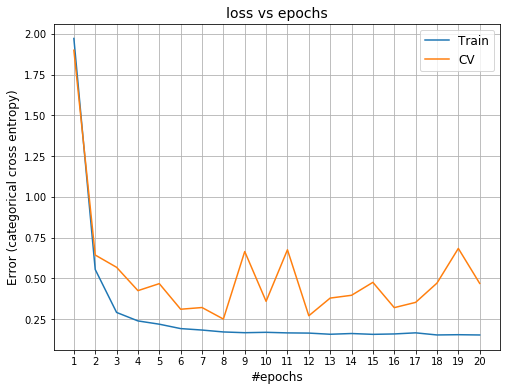

In [62]:
score3_2, train_loss3_2, cv_loss3_2  = report_model(model3_2, history)
table.add_row(['7 ConvNet', 'tanh', 'He-normal','BN + Dropout', round(score3_2[0],5), round(score3_2[1],5)])

### 3.1.2 Weight Initializer (Glorot-Normal)

#### 3.1.2.1 Without Batch Normalization + Dropout

In [63]:
model3_3 = Sequential()
#first ConvNet layer
model3_3.add(Conv2D(24, kernel_size = (7,7), activation = 'tanh', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1), name = 'Conv2D_1',
                 kernel_initializer = glorot_normal(seed = None), data_format = 'channels_last'))

#second ConvNet layer
model3_3.add(Conv2D(50, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_2',
                 kernel_initializer = glorot_normal(seed = None)))

#third ConvNet layer
model3_3.add(Conv2D(70, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_3',
                kernel_initializer = glorot_normal(seed = None)))

#adding MaxPooling
model3_3.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_1'))


#fourth ConvNet layer
model3_3.add(Conv2D(90, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_4',
                kernel_initializer = glorot_normal(seed = None)))

#fifth ConvNet layer
model3_3.add(Conv2D(100, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_5',
                kernel_initializer = glorot_normal(seed = None)))

#sixth ConvNet layer
model3_3.add(Conv2D(110, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_6',
                kernel_initializer = glorot_normal(seed = None)))

#adding MaxPooling
model3_3.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_2'))


#seventh ConvNet layer
model3_3.add(Conv2D(130, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_7',
                kernel_initializer = glorot_normal(seed = None)))

#flatted the ConvNet output
model3_3.add(Flatten(name = 'Flatten_1'))

#add dense layer with tanh activations
model3_3.add(Dense(260, activation = 'tanh', kernel_initializer = glorot_normal(seed = None), name = 'FC_1'))

#add softmax unit
model3_3.add(Dense(num_class, activation = 'softmax', kernel_initializer = glorot_normal(seed = None), name = 'softmax'))

model3_3.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 24)        1200      
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 50)        58850     
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 28, 28, 70)        171570    
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 6, 6, 70)          0         
_________________________________________________________________
Conv2D_4 (Conv2D)            (None, 6, 6, 90)          308790    
_________________________________________________________________
Conv2D_5 (Conv2D)            (None, 6, 6, 100)         441100    
_________________________________________________________________
Conv2D_6 (Conv2D)            (None, 6, 6, 110)       

In [64]:
model3_3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model3_3.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 53s 885us/step - loss: 0.2048 - acc: 0.9338 - val_loss: 0.0480 - val_acc: 0.9854
Epoch 2/20
60000/60000 [==============================] - 49s 815us/step - loss: 0.0615 - acc: 0.9816 - val_loss: 0.0487 - val_acc: 0.9858
Epoch 3/20
60000/60000 [==============================] - 49s 818us/step - loss: 0.0518 - acc: 0.9841 - val_loss: 0.0350 - val_acc: 0.9895
Epoch 4/20
60000/60000 [==============================] - 49s 818us/step - loss: 0.0453 - acc: 0.9860 - val_loss: 0.0436 - val_acc: 0.9874
Epoch 5/20
60000/60000 [==============================] - 49s 817us/step - loss: 0.0423 - acc: 0.9868 - val_loss: 0.0389 - val_acc: 0.9874
Epoch 6/20
60000/60000 [==============================] - 49s 819us/step - loss: 0.0411 - acc: 0.9876 - val_loss: 0.0581 - val_acc: 0.9815
Epoch 7/20
60000/60000 [==============================] - 49s 818us/step - loss: 0.0415 - acc: 0.9873 - val_loss: 0.

Test loss:  0.041349630985222756
Test accuracy:  0.9877


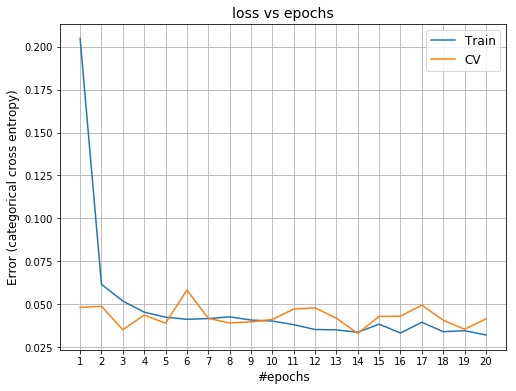

In [65]:
score3_3, train_loss3_3, cv_loss3_3  = report_model(model3_3, history)
table.add_row(['7 ConvNet', 'tanh', 'Glorot-normal','None', round(score3_3[0],5), round(score3_3[1],5)])

#### 3.1.2.2 With Batch Normalization + Dropout

In [66]:
model3_4 = Sequential()
#first ConvNet layer
model3_4.add(Conv2D(24, kernel_size = (7,7), activation = 'tanh', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1), name = 'Conv2D_1',
                 kernel_initializer = glorot_normal(seed = None), data_format = 'channels_last'))
#adding batch normalization
model3_4.add(BatchNormalization(name = 'BN_1'))
#adding dropout
model3_4.add(Dropout(0.5, name = 'Dropout_1'))


#second ConvNet layer
model3_4.add(Conv2D(50, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_2',
                 kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model3_4.add(BatchNormalization(name = 'BN_2'))
#adding dropout
model3_4.add(Dropout(0.5, name = 'Dropout_2'))


#third ConvNet layer
model3_4.add(Conv2D(70, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_3',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model3_4.add(BatchNormalization(name = 'BN_3'))
#adding dropout
model3_4.add(Dropout(0.5, name = 'Dropout_3'))
#adding MaxPooling
model3_4.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_1'))


#fourth ConvNet layer
model3_4.add(Conv2D(90, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_4',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model3_4.add(BatchNormalization(name = 'BN_4'))
#adding dropout
model3_4.add(Dropout(0.5, name = 'Dropout_4'))


#fifth ConvNet layer
model3_4.add(Conv2D(100, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_5',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model3_4.add(BatchNormalization(name = 'BN_5'))
#adding dropout
model3_4.add(Dropout(0.5, name = 'Dropout_5'))


#sixth ConvNet layer
model3_4.add(Conv2D(110, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_6',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model3_4.add(BatchNormalization(name = 'BN_6'))
#adding dropout
model3_4.add(Dropout(0.5, name = 'Dropout_6'))
#adding MaxPooling
model3_4.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_2'))


#seventh ConvNet layer
model3_4.add(Conv2D(130, kernel_size = (7,7), activation = 'tanh', padding = 'same', name = 'Conv2D_7',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model3_4.add(BatchNormalization(name = 'BN_7'))
#adding dropout
model3_4.add(Dropout(0.5, name = 'Dropout_7'))

#flatted the ConvNet output
model3_4.add(Flatten(name = 'Flatten_1'))


#add dense layer with tanh activations
model3_4.add(Dense(260, activation = 'tanh', kernel_initializer = glorot_normal(seed = None), name = 'FC_1'))

#add softmax unit
model3_4.add(Dense(num_class, activation = 'softmax', kernel_initializer = glorot_normal(seed = None), name = 'softmax'))

model3_4.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 24)        1200      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 28, 28, 24)        96        
_________________________________________________________________
Dropout_1 (Dropout)          (None, 28, 28, 24)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 50)        58850     
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 28, 28, 50)        200       
_________________________________________________________________
Dropout_2 (Dropout)          (None, 28, 28, 50)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 28, 28, 70)      

In [67]:
model3_4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model3_4.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 67s 1ms/step - loss: 1.5538 - acc: 0.4051 - val_loss: 0.7475 - val_acc: 0.7669
Epoch 2/20
60000/60000 [==============================] - 61s 1ms/step - loss: 0.3743 - acc: 0.8850 - val_loss: 0.2773 - val_acc: 0.9286
Epoch 3/20
60000/60000 [==============================] - 61s 1ms/step - loss: 0.2529 - acc: 0.9250 - val_loss: 0.8704 - val_acc: 0.7938
Epoch 4/20
60000/60000 [==============================] - 61s 1ms/step - loss: 0.2071 - acc: 0.9389 - val_loss: 0.7293 - val_acc: 0.8443
Epoch 5/20
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1982 - acc: 0.9419 - val_loss: 0.3214 - val_acc: 0.9191
Epoch 6/20
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1872 - acc: 0.9449 - val_loss: 0.4488 - val_acc: 0.8725
Epoch 7/20
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1853 - acc: 0.9452 - val_loss: 0.4594 - val_acc

Test loss:  0.26211785533428195
Test accuracy:  0.9273


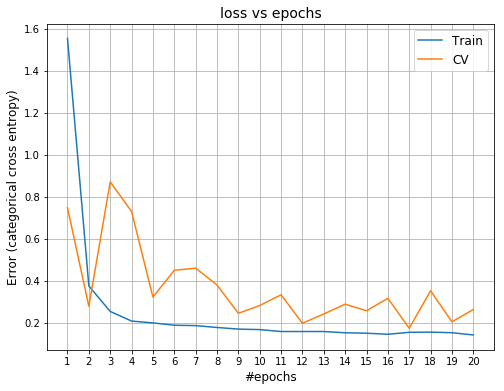

In [68]:
score3_4, train_loss3_4, cv_loss3_4  = report_model(model3_4, history)
table.add_row(['7 ConvNet', 'tanh', 'Glorot-normal','BN + Dropout', round(score3_4[0],5), round(score3_4[1],5)])

## 3.2 With *`ReLU`* Activation

**Architecture**
* Without **BN + Dropout**
  * ***input --> 1<sup>st</sup> ConvNet(7,7)24 --> relu -->  2<sup>nd</sup> ConvNet(7,7)50 --> relu -->  3<sup>rd</sup> ConvNet(7,7)70 --> relu -->  MaxPool[(5,5),s=5] --> 4<sup>th</sup> ConvNet(7,7)90 --> relu -->  5<sup>th</sup> ConvNet(7,7)100 --> relu -->  6<sup>th</sup> ConvNet(7,7)110 --> relu -->  MaxPool[(5,5),s=5] --> 7<sup>th</sup> ConvNet(7,7)130 -->  flatten --> F.C.(260) --> softmax(10)***
* With **BN + Dropout**
  * ***input --> 1<sup>st</sup> ConvNet(7,7)24 --> relu --> Batch Nomralization+dropout --> 2<sup>nd</sup> ConvNet(7,7)50 --> relu --> Batch Nomralization+dropout --> 3<sup>rd</sup> ConvNet(7,7)70 --> relu --> Batch Nomralization+dropout --> MaxPool[(5,5),s=5] --> 4<sup>th</sup> ConvNet(7,7)90 --> relu --> Batch Nomralization+dropout --> 5<sup>th</sup> ConvNet(7,7)100 --> relu --> Batch Nomralization+dropout --> 6<sup>th</sup> ConvNet(7,7)110 --> relu --> Batch Nomralization+dropout --> MaxPool[(5,5),s=5] --> 7<sup>th</sup> ConvNet(7,7)130 --> Batch Nomralization+dropout --> flatten --> F.C.(260) --> softmax(10)***

### 3.2.1 Weight Initializer (He-Normal)

#### 3.1.2.1 Without Batch Normalization + Dropout

In [69]:
model3_5 = Sequential()
#first ConvNet layer
model3_5.add(Conv2D(24, kernel_size = (7,7), activation = 'relu', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1), name = 'Conv2D_1',
                 kernel_initializer = he_normal(seed = None), data_format = 'channels_last'))

#second ConvNet layer
model3_5.add(Conv2D(50, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_2',
                 kernel_initializer = he_normal(seed = None)))

#third ConvNet layer
model3_5.add(Conv2D(70, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_3',
                kernel_initializer = he_normal(seed = None)))

#adding MaxPooling
model3_5.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_1'))


#fourth ConvNet layer
model3_5.add(Conv2D(90, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_4',
                kernel_initializer = he_normal(seed = None)))

#fifth ConvNet layer
model3_5.add(Conv2D(100, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_5',
                kernel_initializer = he_normal(seed = None)))

#sixth ConvNet layer
model3_5.add(Conv2D(110, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_6',
                kernel_initializer = he_normal(seed = None)))

#adding MaxPooling
model3_5.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_2'))


#seventh ConvNet layer
model3_5.add(Conv2D(130, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_7',
                kernel_initializer = he_normal(seed = None)))

#flatted the ConvNet output
model3_5.add(Flatten(name = 'Flatten_1'))

#add dense layer with relu activations
model3_5.add(Dense(260, activation = 'relu', kernel_initializer = he_normal(seed = None), name = 'FC_1'))

#add softmax unit
model3_5.add(Dense(num_class, activation = 'softmax', kernel_initializer = he_normal(seed = None), name = 'softmax'))

model3_5.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 24)        1200      
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 50)        58850     
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 28, 28, 70)        171570    
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 6, 6, 70)          0         
_________________________________________________________________
Conv2D_4 (Conv2D)            (None, 6, 6, 90)          308790    
_________________________________________________________________
Conv2D_5 (Conv2D)            (None, 6, 6, 100)         441100    
_________________________________________________________________
Conv2D_6 (Conv2D)            (None, 6, 6, 110)       

In [70]:
model3_5.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model3_5.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 54s 892us/step - loss: 0.2367 - acc: 0.9240 - val_loss: 0.0619 - val_acc: 0.9831
Epoch 2/20
60000/60000 [==============================] - 49s 811us/step - loss: 0.0493 - acc: 0.9858 - val_loss: 0.0439 - val_acc: 0.9869
Epoch 3/20
60000/60000 [==============================] - 49s 810us/step - loss: 0.0337 - acc: 0.9905 - val_loss: 0.0343 - val_acc: 0.9899
Epoch 4/20
60000/60000 [==============================] - 48s 803us/step - loss: 0.0299 - acc: 0.9917 - val_loss: 0.0473 - val_acc: 0.9885
Epoch 5/20
60000/60000 [==============================] - 48s 803us/step - loss: 0.0243 - acc: 0.9931 - val_loss: 0.0395 - val_acc: 0.9904
Epoch 6/20
60000/60000 [==============================] - 48s 801us/step - loss: 0.0218 - acc: 0.9941 - val_loss: 0.0297 - val_acc: 0.9926
Epoch 7/20
60000/60000 [==============================] - 48s 800us/step - loss: 0.0174 - acc: 0.9953 - val_loss: 0.

Test loss:  0.13076017924296807
Test accuracy:  0.9835


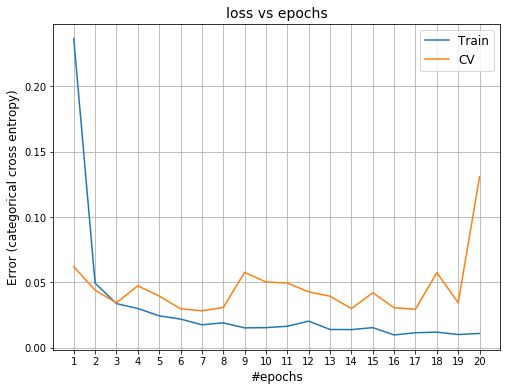

In [71]:
score3_5, train_loss3_5, cv_loss3_5  = report_model(model3_5, history)
table.add_row(['7 ConvNet', 'relu', 'He-normal','None', round(score3_5[0],5), round(score3_5[1],5)])

#### 3.1.2.2 With Batch Normalization + Dropout

In [72]:
model3_6 = Sequential()
#first ConvNet layer
model3_6.add(Conv2D(24, kernel_size = (7,7), activation = 'relu', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1), name = 'Conv2D_1',
                 kernel_initializer = he_normal(seed = None), data_format = 'channels_last'))
#adding batch normalization
model3_6.add(BatchNormalization(name = 'BN_1'))
#adding dropout
model3_6.add(Dropout(0.5, name = 'Dropout_1'))


#second ConvNet layer
model3_6.add(Conv2D(50, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_2',
                 kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model3_6.add(BatchNormalization(name = 'BN_2'))
#adding dropout
model3_6.add(Dropout(0.5, name = 'Dropout_2'))


#third ConvNet layer
model3_6.add(Conv2D(70, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_3',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model3_6.add(BatchNormalization(name = 'BN_3'))
#adding dropout
model3_6.add(Dropout(0.5, name = 'Dropout_3'))
#adding MaxPooling
model3_6.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_1'))


#fourth ConvNet layer
model3_6.add(Conv2D(90, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_4',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model3_6.add(BatchNormalization(name = 'BN_4'))
#adding dropout
model3_6.add(Dropout(0.5, name = 'Dropout_4'))


#fifth ConvNet layer
model3_6.add(Conv2D(100, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_5',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model3_6.add(BatchNormalization(name = 'BN_5'))
#adding dropout
model3_6.add(Dropout(0.5, name = 'Dropout_5'))


#sixth ConvNet layer
model3_6.add(Conv2D(110, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_6',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model3_6.add(BatchNormalization(name = 'BN_6'))
#adding dropout
model3_6.add(Dropout(0.5, name = 'Dropout_6'))
#adding MaxPooling
model3_6.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_2'))


#seventh ConvNet layer
model3_6.add(Conv2D(130, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_7',
                kernel_initializer = he_normal(seed = None)))
#adding batch normalization
model3_6.add(BatchNormalization(name = 'BN_7'))
#adding dropout
model3_6.add(Dropout(0.5, name = 'Dropout_7'))

#flatted the ConvNet output
model3_6.add(Flatten(name = 'Flatten_1'))


#add dense layer with relu activations
model3_6.add(Dense(260, activation = 'relu', kernel_initializer = he_normal(seed = None), name = 'FC_1'))

#add softmax unit
model3_6.add(Dense(num_class, activation = 'softmax', kernel_initializer = he_normal(seed = None), name = 'softmax'))

model3_6.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 24)        1200      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 28, 28, 24)        96        
_________________________________________________________________
Dropout_1 (Dropout)          (None, 28, 28, 24)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 50)        58850     
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 28, 28, 50)        200       
_________________________________________________________________
Dropout_2 (Dropout)          (None, 28, 28, 50)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 28, 28, 70)      

In [73]:
model3_6.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model3_6.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 69s 1ms/step - loss: 0.6617 - acc: 0.7735 - val_loss: 2.9269 - val_acc: 0.4200
Epoch 2/20
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1115 - acc: 0.9666 - val_loss: 1.1207 - val_acc: 0.6676
Epoch 3/20
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0826 - acc: 0.9755 - val_loss: 0.8556 - val_acc: 0.7656
Epoch 4/20
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0638 - acc: 0.9808 - val_loss: 0.2321 - val_acc: 0.9278
Epoch 5/20
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0561 - acc: 0.9837 - val_loss: 0.5641 - val_acc: 0.8212
Epoch 6/20
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0445 - acc: 0.9869 - val_loss: 0.2550 - val_acc: 0.9228
Epoch 8/20
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0414 - acc: 0.9878 - val_loss: 0.1131 - val_acc

Test loss:  0.054001326436176895
Test accuracy:  0.9813


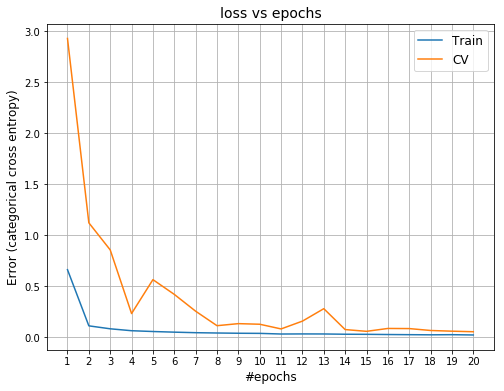

In [74]:
score3_6, train_loss3_6, cv_loss3_6  = report_model(model3_6, history)
table.add_row(['7 ConvNet', 'relu', 'He-normal','BN + Dropout', round(score3_6[0],5), round(score3_6[1],5)])

### 3.2.2 Weight Initializer (Glorot-Normal)

#### 3.2.2.1 Without Batch Normalization + Dropout

In [75]:
model3_7 = Sequential()
#first ConvNet layer
model3_7.add(Conv2D(24, kernel_size = (7,7), activation = 'relu', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1), name = 'Conv2D_1',
                 kernel_initializer = glorot_normal(seed = None), data_format = 'channels_last'))

#second ConvNet layer
model3_7.add(Conv2D(50, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_2',
                 kernel_initializer = glorot_normal(seed = None)))

#third ConvNet layer
model3_7.add(Conv2D(70, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_3',
                kernel_initializer = glorot_normal(seed = None)))

#adding MaxPooling
model3_7.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_1'))


#fourth ConvNet layer
model3_7.add(Conv2D(90, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_4',
                kernel_initializer = glorot_normal(seed = None)))

#fifth ConvNet layer
model3_7.add(Conv2D(100, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_5',
                kernel_initializer = glorot_normal(seed = None)))

#sixth ConvNet layer
model3_7.add(Conv2D(110, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_6',
                kernel_initializer = glorot_normal(seed = None)))

#adding MaxPooling
model3_7.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_2'))


#seventh ConvNet layer
model3_7.add(Conv2D(130, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_7',
                kernel_initializer = glorot_normal(seed = None)))

#flatted the ConvNet output
model3_7.add(Flatten(name = 'Flatten_1'))

#add dense layer with relu activations
model3_7.add(Dense(260, activation = 'relu', kernel_initializer = glorot_normal(seed = None), name = 'FC_1'))

#add softmax unit
model3_7.add(Dense(num_class, activation = 'softmax', kernel_initializer = glorot_normal(seed = None), name = 'softmax'))

model3_7.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 24)        1200      
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 50)        58850     
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 28, 28, 70)        171570    
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 6, 6, 70)          0         
_________________________________________________________________
Conv2D_4 (Conv2D)            (None, 6, 6, 90)          308790    
_________________________________________________________________
Conv2D_5 (Conv2D)            (None, 6, 6, 100)         441100    
_________________________________________________________________
Conv2D_6 (Conv2D)            (None, 6, 6, 110)       

In [76]:
model3_7.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model3_7.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 53s 891us/step - loss: 0.6120 - acc: 0.7733 - val_loss: 0.0719 - val_acc: 0.9775
Epoch 2/20
60000/60000 [==============================] - 48s 800us/step - loss: 0.0640 - acc: 0.9818 - val_loss: 0.0515 - val_acc: 0.9851
Epoch 3/20
60000/60000 [==============================] - 48s 798us/step - loss: 0.0441 - acc: 0.9874 - val_loss: 0.0383 - val_acc: 0.9883
Epoch 4/20
60000/60000 [==============================] - 48s 797us/step - loss: 0.0354 - acc: 0.9904 - val_loss: 0.0337 - val_acc: 0.9901
Epoch 5/20
60000/60000 [==============================] - 48s 797us/step - loss: 0.0310 - acc: 0.9910 - val_loss: 0.0330 - val_acc: 0.9908
Epoch 6/20
60000/60000 [==============================] - 48s 797us/step - loss: 0.0242 - acc: 0.9933 - val_loss: 0.0310 - val_acc: 0.9904
Epoch 7/20
60000/60000 [==============================] - 48s 796us/step - loss: 0.0229 - acc: 0.9935 - val_loss: 0.

Test loss:  0.05397138358984057
Test accuracy:  0.9882


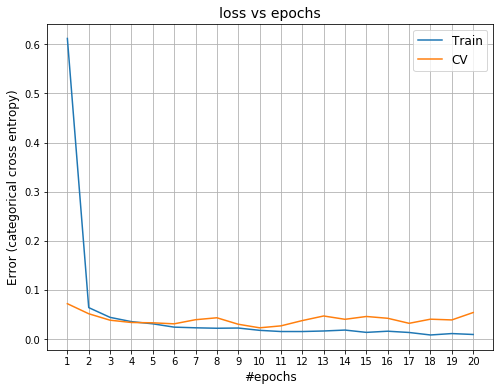

In [77]:
score3_7, train_loss3_7, cv_loss3_7  = report_model(model3_7, history)
table.add_row(['7 ConvNet', 'relu', 'Glorot-normal','None', round(score3_7[0],5), round(score3_7[1],5)])

#### 3.2.2.2 With Batch Normalization + Dropout

In [78]:
model3_8 = Sequential()
#first ConvNet layer
model3_8.add(Conv2D(24, kernel_size = (7,7), activation = 'relu', padding = 'same', 
                 input_shape = (X_train.shape[1], X_train.shape[2],1), name = 'Conv2D_1',
                 kernel_initializer = glorot_normal(seed = None), data_format = 'channels_last'))
#adding batch normalization
model3_8.add(BatchNormalization(name = 'BN_1'))
#adding dropout
model3_8.add(Dropout(0.5, name = 'Dropout_1'))


#second ConvNet layer
model3_8.add(Conv2D(50, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_2',
                 kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model3_8.add(BatchNormalization(name = 'BN_2'))
#adding dropout
model3_8.add(Dropout(0.5, name = 'Dropout_2'))


#third ConvNet layer
model3_8.add(Conv2D(70, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_3',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model3_8.add(BatchNormalization(name = 'BN_3'))
#adding dropout
model3_8.add(Dropout(0.5, name = 'Dropout_3'))
#adding MaxPooling
model3_8.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_1'))


#fourth ConvNet layer
model3_8.add(Conv2D(90, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_4',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model3_8.add(BatchNormalization(name = 'BN_4'))
#adding dropout
model3_8.add(Dropout(0.5, name = 'Dropout_4'))


#fifth ConvNet layer
model3_8.add(Conv2D(100, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_5',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model3_8.add(BatchNormalization(name = 'BN_5'))
#adding dropout
model3_8.add(Dropout(0.5, name = 'Dropout_5'))


#sixth ConvNet layer
model3_8.add(Conv2D(110, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_6',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model3_8.add(BatchNormalization(name = 'BN_6'))
#adding dropout
model3_8.add(Dropout(0.5, name = 'Dropout_6'))
#adding MaxPooling
model3_8.add(MaxPooling2D(pool_size = (5,5), strides = 5, padding = 'same', name = 'max_pool_2'))


#seventh ConvNet layer
model3_8.add(Conv2D(130, kernel_size = (7,7), activation = 'relu', padding = 'same', name = 'Conv2D_7',
                kernel_initializer = glorot_normal(seed = None)))
#adding batch normalization
model3_8.add(BatchNormalization(name = 'BN_7'))
#adding dropout
model3_8.add(Dropout(0.5, name = 'Dropout_7'))

#flatted the ConvNet output
model3_8.add(Flatten(name = 'Flatten_1'))


#add dense layer with relu activations
model3_8.add(Dense(260, activation = 'relu', kernel_initializer = glorot_normal(seed = None), name = 'FC_1'))

#add softmax unit
model3_8.add(Dense(num_class, activation = 'softmax', kernel_initializer = glorot_normal(seed = None), name = 'softmax'))

model3_8.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 28, 28, 24)        1200      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 28, 28, 24)        96        
_________________________________________________________________
Dropout_1 (Dropout)          (None, 28, 28, 24)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 28, 50)        58850     
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 28, 28, 50)        200       
_________________________________________________________________
Dropout_2 (Dropout)          (None, 28, 28, 50)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 28, 28, 70)      

In [79]:
model3_8.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model3_8.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 69s 1ms/step - loss: 0.6157 - acc: 0.7836 - val_loss: 1.8927 - val_acc: 0.4750
Epoch 2/20
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0950 - acc: 0.9716 - val_loss: 0.6932 - val_acc: 0.7667
Epoch 3/20
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0700 - acc: 0.9789 - val_loss: 0.3493 - val_acc: 0.9040
Epoch 4/20
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0579 - acc: 0.9825 - val_loss: 0.3276 - val_acc: 0.9074
Epoch 5/20
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0528 - acc: 0.9845 - val_loss: 0.3297 - val_acc: 0.9110
Epoch 6/20
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0467 - acc: 0.9866 - val_loss: 0.2311 - val_acc: 0.9330
Epoch 7/20
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0420 - acc: 0.9880 - val_loss: 0.3135 - val_acc

Test loss:  0.04358525695521384
Test accuracy:  0.9884


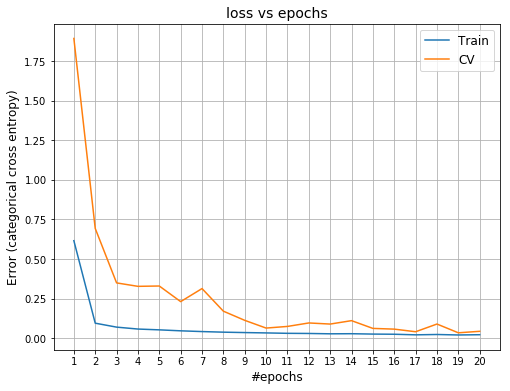

In [80]:
score3_8, train_loss3_8, cv_loss3_8  = report_model(model3_8, history)
table.add_row(['7 ConvNet', 'relu', 'Glorot-normal','BN + Dropout', round(score3_8[0],5), round(score3_8[1],5)])

# Conclusion

* For each model I've taken only 20 epochs. 
* **3-ConvNet** layers with **ReLU** actvation, **He-normal** initialization and without **BN+Dropout** is giving best performance. It has loss = 0.03006 and accuracy = 99.42%.
* Model with 5-ConvNet layers + relu activation + He-normal inintailization has very good performance. This model without **BN+Dropout** has loss = 0.03125 and accuracy = 99.34% and with **BN+Dropout** has loss = 0.03502 and accuracy = 99.26%.
* Models with 7-ConvNet layers do not very good performance. The reasons behind this can be the small training data and deep architecture. Even with 7-ConvNet layers.
* Generally, He-normalization with ReLU activation work better.

In [81]:
print(table)

+--------------+------------+-----------------+--------------+-----------+---------------+
| Architecture | Activation | W's Initializer | Regularizer  | Test Loss | Test Accuracy |
+--------------+------------+-----------------+--------------+-----------+---------------+
|  3 ConvNet   |    tanh    |    He-normal    |     None     |  0.04717  |     0.9872    |
|  3 ConvNet   |    tanh    |    He-normal    | BN + Dropout |  0.04299  |     0.9859    |
|  3 ConvNet   |    tanh    |  Glorot-normal  |     None     |  0.04693  |     0.9874    |
|  3 ConvNet   |    tanh    |  Glorot-normal  | BN + Dropout |  0.03855  |     0.9873    |
|  3 ConvNet   |    relu    |    He-normal    |     None     |  0.03006  |     0.9942    |
|  3 ConvNet   |    relu    |    He-normal    | BN + Dropout |  0.03696  |     0.9897    |
|  3 ConvNet   |    relu    |  Glorot-normal  |     None     |  0.03346  |     0.9914    |
|  3 ConvNet   |    relu    |  Glorot-normal  | BN + Dropout |  0.04196  |     0.9867    |